## Evaluador de rendimiento de Lervis

En este proyecto el nivel INFO se emplea unicamente a modo de notificacion en la consola y de registro en los logs, pero no se emplea para la recogida de datos y su evaluacion. Para esto, unicamente se empleara el nivel **DEBUG**.

A su vez, que tampoco se evaluara el proceso de ETL_inicial ya que al lanzarse incialmente, carece de sentido de su evaluacion constante.

In [562]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os

## LOG PATHS

In [563]:
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))
LOG_DIR = os.path.join(BASE_DIR, 'Logs')

In [564]:
# RAG
RAG_LOG_PATH = os.path.join(LOG_DIR, 'rag_evaluator.log')
#ETL
ETL_DIARIA_LOG_PATH = os.path.join(LOG_DIR, 'ETL_diaria.log')
# MODELOS

DOCLING_LOG_PATH = os.path.join(LOG_DIR, 'Docling_OCR.log')

EMBEDDING_USER_LOG_PATH = os.path.join(LOG_DIR, 'Embedding.log')

EMBEDDING_RESUMEN_LOG_PATH = os.path.join(LOG_DIR, 'Embedding_chunk_Doc_Enri_ETL.log')

EMBEDDING_CHUNK_LOG_PATH = os.path.join(LOG_DIR, 'Embedding_chunks_ETL.log')

FLORENCE2_LOG_PATH = os.path.join(LOG_DIR, 'florence2.log')

FUNCIONES_BBDD_LOG_PATH = os.path.join(LOG_DIR, 'funciones_BDDD.log')

LLM_INTENCION_LOG_PATH = os.path.join(LOG_DIR, 'Llama3_1_intencion.log')

LLM_LOG_PATH = os.path.join(LOG_DIR, 'Llama3_1.log')

TRADUCTOR_LOG_PATH = os.path.join(LOG_DIR, 'Traductor.log')

## RAG

In [565]:
RAG = pd.read_csv(RAG_LOG_PATH, delimiter='|')

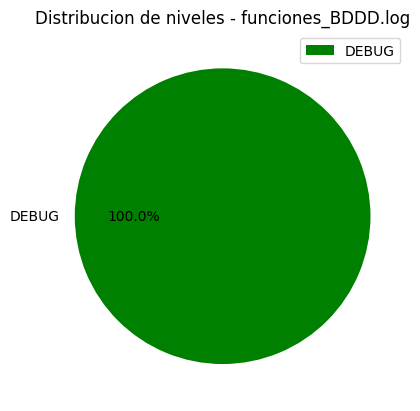

In [566]:
RAG['level'].value_counts().plot(
    kind='pie',
    autopct='%1.1f%%',
    colors=['green', 'red'], 
    ylabel=''
)
plt.title('Distribucion de niveles - funciones_BDDD.log')
plt.legend()
plt.show()

#### Generacion del Dataframe

In [567]:
timestamp = []
rag_flow = []
longitud_user = []
longitud_llm = []
sim_coseno = []
sim_jaccard = []
ROUGE_1_precision = []
ROUGE_1_recall = []
ROUGE_1_F1 = []
ROUGE_2_precision = []
ROUGE_2_recall = []
ROUGE_2_F1 = []
ROUGE_L_precision = []
ROUGE_L_recall = []
ROUGE_L_F1 = []


for row in RAG.itertuples():
    mensaje = row.message.split(',')    
    
    rag_flow.append(mensaje[0].split('-')[-1].strip())
    longitud_user.append(int(mensaje[1].split('-')[-1]))
    longitud_llm.append(int(mensaje[2].split('-')[-1]))
    sim_coseno.append(float(mensaje[3].split('-')[-1]))
    sim_jaccard.append(float(mensaje[4].split('-')[-1]))

    ROUGE_1_precision.append(float(mensaje[5].split('-')[-1]))
    ROUGE_1_recall.append(float(mensaje[6].split('-')[-1]))
    ROUGE_1_F1.append(float(mensaje[7].split('-')[-1]))

    ROUGE_2_precision.append(float(mensaje[8].split('-')[-1]))
    ROUGE_2_recall.append(float(mensaje[9].split('-')[-1]))
    ROUGE_2_F1.append(float(mensaje[10].split('-')[-1]))

    ROUGE_L_precision.append(float(mensaje[11].split('-')[-1]))
    ROUGE_L_recall.append(float(mensaje[12].split('-')[-1]))
    ROUGE_L_F1.append(float(mensaje[13].split('-')[-1]))
    timestamp.append(datetime.strptime(row.timestamp, "%Y-%m-%d %H:%M:%S,%f"))

RAG_DF = pd.DataFrame({
    'timestamp': timestamp,
    'rag_flow': rag_flow,
    'longitud_user': longitud_user,
    'longitud_llm': longitud_llm,
    'sim_coseno': sim_coseno,
    'sim_jaccard': sim_jaccard,
    'ROUGE_1_precision': ROUGE_1_precision,
    'ROUGE_1_recall': ROUGE_1_recall,
    'ROUGE_1_F1': ROUGE_1_F1,
    'ROUGE_2_precision': ROUGE_2_precision,
    'ROUGE_2_recall': ROUGE_2_recall,
    'ROUGE_2_F1': ROUGE_2_F1,
    'ROUGE_L_precision': ROUGE_L_precision,
    'ROUGE_L_recall': ROUGE_L_recall,
    'ROUGE_L_F1': ROUGE_L_F1
})

In [568]:
RAG_DF['rag_flow'].unique()

array(['hablar', 'consultar_docs_chunk', 'consultar_docs_resumen',
       'consultar_temp', 'id_arxiv', '', 'recuperacion_vacia',
       'desconocido'], dtype=object)

In [662]:
subset_RAG_DF = RAG_DF[RAG_DF['rag_flow'].isin(['hablar', 'consultar_docs_chunk', 'consultar_docs_resumen', 'id_arxiv', 'recuperacion_vacia'])]

In [663]:
subset_RAG_DF['rag_flow'].unique()

array(['hablar', 'consultar_docs_chunk', 'consultar_docs_resumen',
       'id_arxiv', 'recuperacion_vacia'], dtype=object)

In [664]:
hablar_df = RAG_DF[RAG_DF['rag_flow'] == 'hablar']
consultar_resumen_df = RAG_DF[RAG_DF['rag_flow'] == 'consultar_docs_resumen']
consultar_fragmentos_df = RAG_DF[RAG_DF['rag_flow'] == 'consultar_docs_chunk']
recuperacion_vacia_df = RAG_DF[RAG_DF['rag_flow'] == 'recuperacion_vacia']

In [665]:
subset_RAG_DF.groupby('rag_flow')['sim_coseno'].mean().sort_values(ascending=False)

rag_flow
consultar_docs_resumen    0.632938
consultar_docs_chunk      0.606335
recuperacion_vacia        0.560300
hablar                    0.419222
id_arxiv                  0.335527
Name: sim_coseno, dtype: float64

#### Distribución de flujos rag

In [666]:
subset_RAG_DF['rag_flow'].value_counts()

rag_flow
hablar                    25
consultar_docs_chunk      15
recuperacion_vacia        12
id_arxiv                   9
consultar_docs_resumen     8
Name: count, dtype: int64

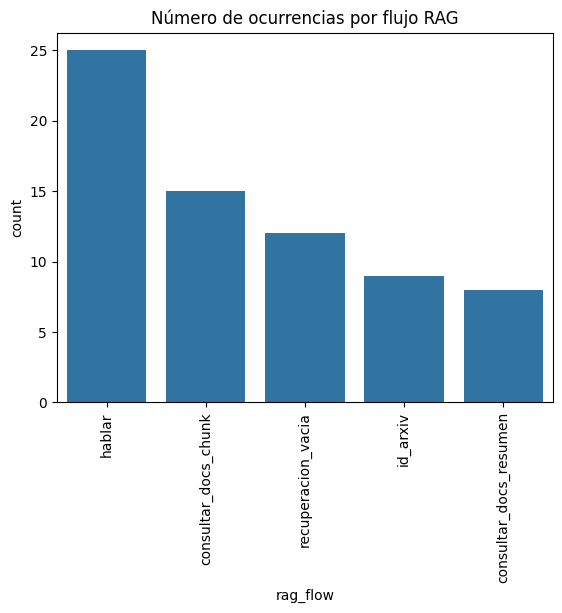

In [667]:
sns.barplot(subset_RAG_DF['rag_flow'].value_counts())
plt.xticks(rotation=90)
plt.title('Número de ocurrencias por flujo RAG')
plt.show()

#### Boxplots Similitud de coseno por flujo RAG

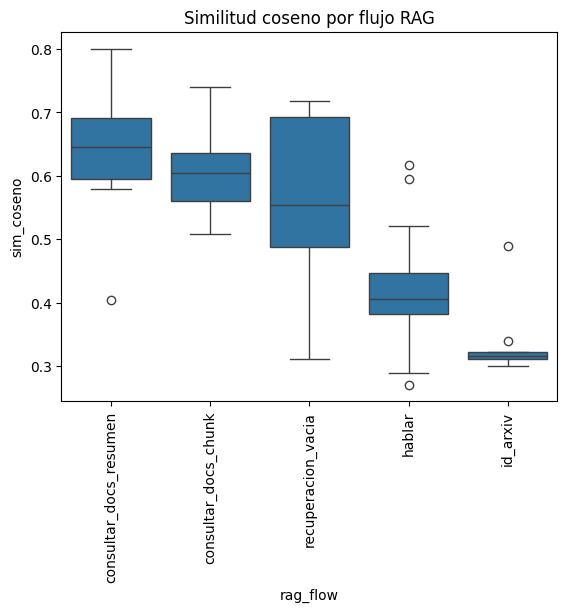

In [673]:
sns.boxplot(data=subset_RAG_DF.sort_values('sim_coseno', ascending=False), x='rag_flow', y='sim_coseno')
plt.title('Similitud coseno por flujo RAG')
plt.xticks(rotation=90)
plt.show()

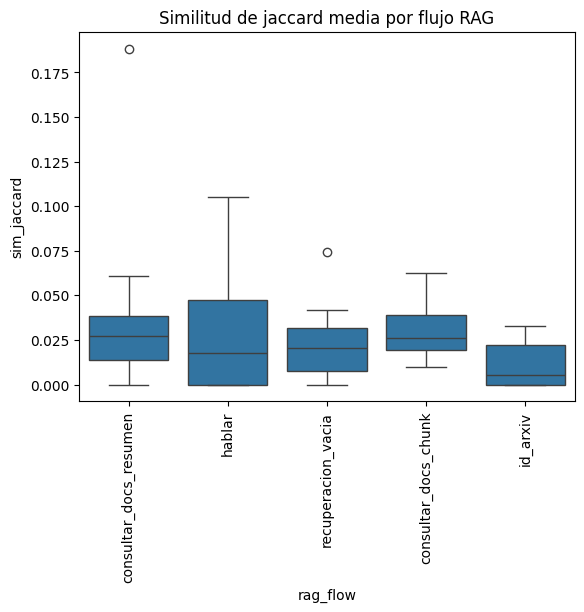

In [674]:
sns.boxplot(data=subset_RAG_DF.sort_values('sim_jaccard', ascending=False), x='rag_flow', y='sim_jaccard')
plt.title('Similitud de jaccard media por flujo RAG')
plt.xticks(rotation=90)
plt.show()

#### Boxplot ROUGE Recall 1,2,L

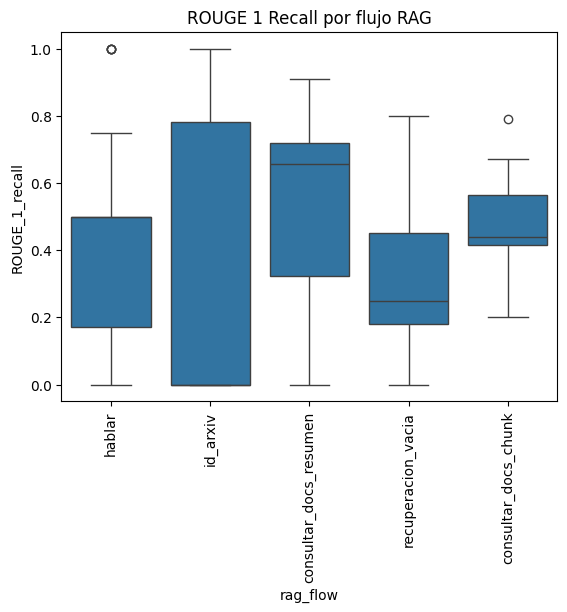

In [679]:
sns.boxplot(data=subset_RAG_DF.sort_values('ROUGE_1_recall', ascending=False), x='rag_flow', y='ROUGE_1_recall')
plt.title('ROUGE 1 Recall por flujo RAG')
plt.xticks(rotation=90)
plt.show()

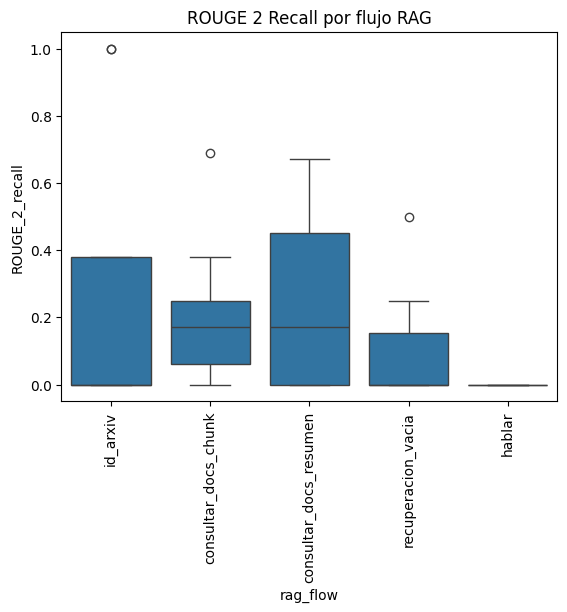

In [680]:
sns.boxplot(data=subset_RAG_DF.sort_values('ROUGE_2_recall', ascending=False), x='rag_flow', y='ROUGE_2_recall')
plt.title('ROUGE 2 Recall por flujo RAG')
plt.xticks(rotation=90)
plt.show()

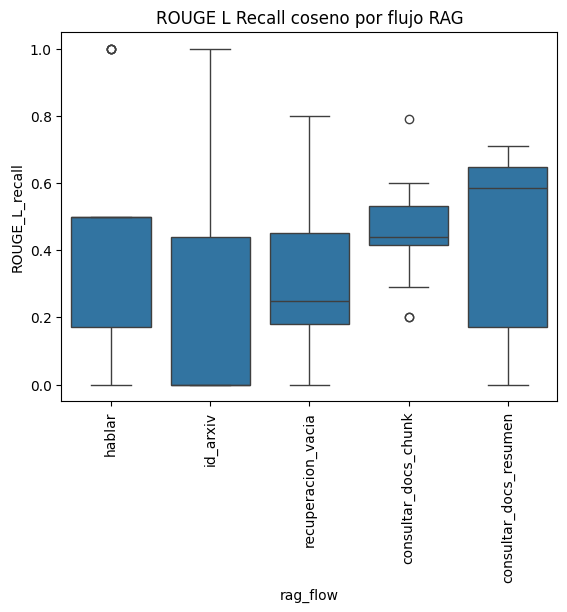

In [678]:
sns.boxplot(data=subset_RAG_DF.sort_values('ROUGE_L_recall', ascending=False), x='rag_flow', y='ROUGE_L_recall')
plt.title('ROUGE L Recall coseno por flujo RAG')
plt.xticks(rotation=90)
plt.show()

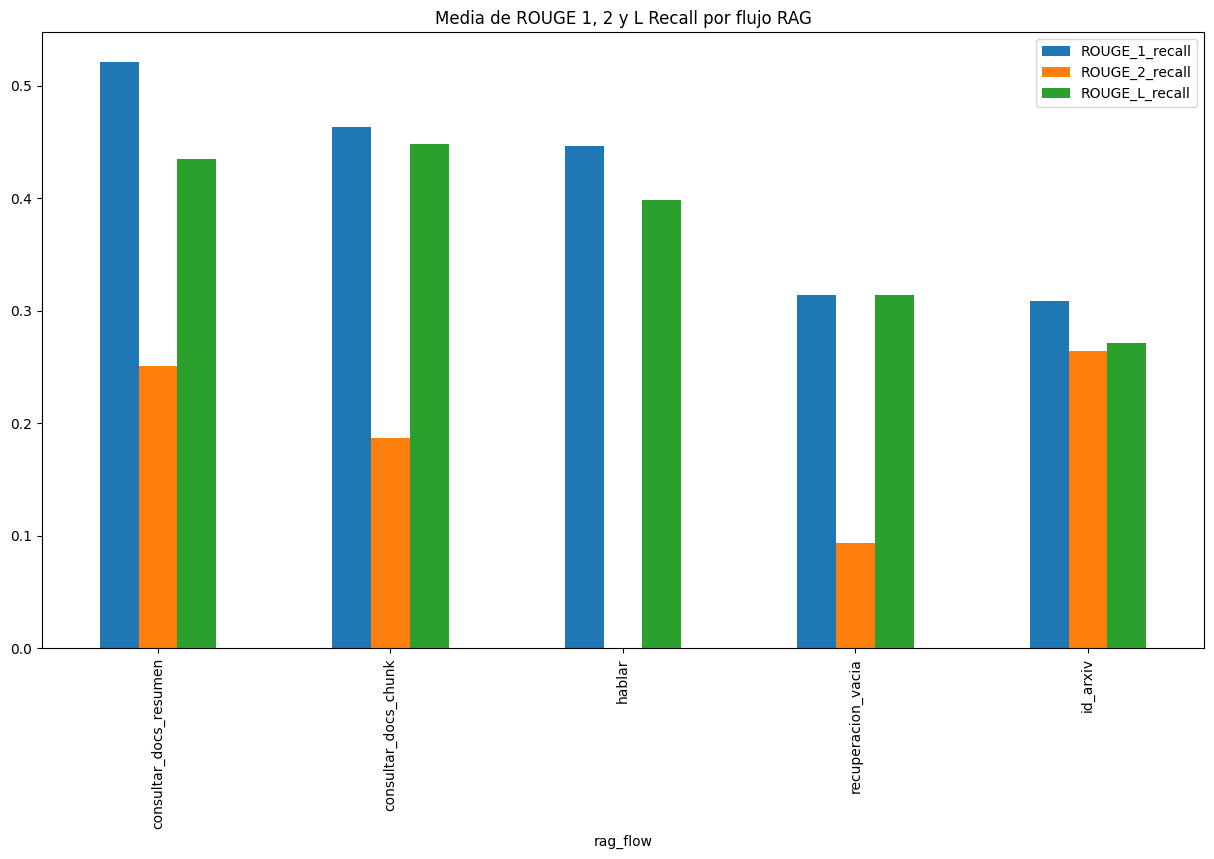

In [686]:
subset_RAG_DF.groupby('rag_flow').agg({
    'ROUGE_1_recall': 'mean',
    'ROUGE_2_recall': 'mean',
    'ROUGE_L_recall': 'mean',
}).sort_values('ROUGE_1_recall', ascending=False).plot(kind='bar', figsize=(15, 8))
plt.title('Media de ROUGE 1, 2 y L Recall por flujo RAG')
plt.show()

## ETL

### ETL Diaria

In [575]:
ETL_D_df = pd.read_csv(ETL_DIARIA_LOG_PATH, delimiter='|')

In [576]:
ETL_D_df = ETL_D_df[ETL_D_df['level'] != 'INFO']

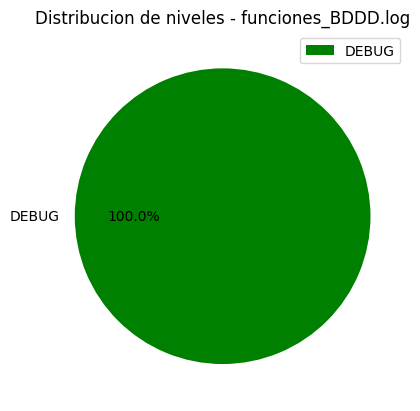

In [577]:
ETL_D_df['level'].value_counts().plot(
    kind='pie',
    autopct='%1.1f%%',
    colors=['green', 'red'], 
    ylabel=''
)
plt.title('Distribucion de niveles - funciones_BDDD.log')
plt.legend()
plt.show()

In [578]:
subset_debug_ETL_D = ETL_D_df[ETL_D_df['level'] == 'DEBUG']

#### Generacion de los dataframes

In [579]:
# ------Archivo Temporal
archivo_temporal_timestamp = []
archivo_temporal_duracion = []
archivo_temporal_arxivid = []

# ------ Segmentacion Doc
segmentacion_timestamp = []
segmentacion_id = []

# ------Enriquecimiento Doc
enri_doct_timestamp = []
enri_doct_duracion = []
enri_doct__arxivid = []

# ------Chunking documento enriquecido
chunking_enri_doc_timestamp = []
chunking_enri_doc_cantidad = []
chunking_enri_doc_duracion = []
chunking_enri_doc_arxivid = []

# ------ Carga BBDD documento enriquecido
carga_db_doc_enri_timestamp = []
carga_db_doc_enri_duracion = []
carga_db_doc_enri_arxivid = []

# ------ Carga BBDD chunk
carga_db_chunk_timestamp = []
carga_db_chunk_duracion = []
carga_db_chunk_arxivid = []

# ------ Carga BBDD resumen
carga_db_resumen_timestamp = []
carga_db_resumen_duracion = []
carga_db_resumen_arxivid = []

# ------ Totales
totales_timestamp = []
totales_duracion = []
totales_chunks = []
totales_embeddings = []
totales_publicaciones = []

for row in subset_debug_ETL_D.itertuples():
    mensaje = row.message
    #print(mensaje)
    if 'Archivo temporal' in mensaje:
        archivo_temporal_duracion.append(float(mensaje.split('-')[1].split(':')[-1]))
        archivo_temporal_arxivid.append(mensaje.split('-')[2].split(':')[-1].strip())
        archivo_temporal_timestamp.append(datetime.strptime(row.timestamp, "%Y-%m-%d %H:%M:%S,%f").date())
    elif 'Segmentacion del documento' in mensaje:

        segmentacion_id.append(mensaje.split('-')[2].split(':')[-1])
        segmentacion_timestamp.append(datetime.strptime(row.timestamp, "%Y-%m-%d %H:%M:%S,%f"))

    
    elif 'Enriquecimiento del documento' in mensaje:
        enri_doct_duracion.append(float(mensaje.split('-')[1].split(':')[-1]))
        enri_doct__arxivid.append(mensaje.split('-')[2].split(':')[-1].strip())
        enri_doct_timestamp.append(datetime.strptime(row.timestamp, "%Y-%m-%d %H:%M:%S,%f").date())

    elif 'Chunking del documento enriquecido' in mensaje:
        chunking_enri_doc_cantidad.append(int(mensaje.split('-')[1].split(':')[-1]))
        chunking_enri_doc_duracion.append(float(mensaje.split('-')[2].split(':')[-1]))
        chunking_enri_doc_arxivid.append(mensaje.split('-')[3].split(':')[-1].strip())
        chunking_enri_doc_timestamp.append(datetime.strptime(row.timestamp, "%Y-%m-%d %H:%M:%S,%f").date())

    elif 'Carga del documento enriquecido' in mensaje:
        carga_db_doc_enri_duracion.append(float(mensaje.split('-')[1].split(':')[-1]))
        carga_db_doc_enri_arxivid.append(mensaje.split('-')[2].split(':')[-1].strip())
        carga_db_doc_enri_timestamp.append(datetime.strptime(row.timestamp, "%Y-%m-%d %H:%M:%S,%f").date())
        

    elif 'Insercion del chunk' in mensaje:
        carga_db_chunk_duracion.append(float(mensaje.split('-')[1].split(':')[-1]))
        carga_db_chunk_arxivid.append(mensaje.split('-')[2].split(':')[-1].strip())
        carga_db_chunk_timestamp.append(datetime.strptime(row.timestamp, "%Y-%m-%d %H:%M:%S,%f").date())
        #print(mensaje.split('-'))

    elif 'Insercion del resumen' in mensaje:
        carga_db_resumen_duracion.append(float(mensaje.split('-')[1].split(':')[-1]))
        carga_db_resumen_arxivid.append(mensaje.split('-')[2].split(':')[-1].strip())
        carga_db_resumen_timestamp.append(datetime.strptime(row.timestamp, "%Y-%m-%d %H:%M:%S,%f").date())

    elif 'ETL inicial finalizado con exito' in mensaje:
        totales_duracion.append(float(mensaje.split('-')[1].split(':')[-1]))
        totales_publicaciones.append(int(mensaje.split('-')[2].split(':')[-1]))
        totales_chunks.append(int(mensaje.split('-')[3].split(':')[-1]))
        totales_embeddings.append(int(mensaje.split('-')[4].split(':')[-1]))
        totales_timestamp.append(datetime.strptime(row.timestamp, "%Y-%m-%d %H:%M:%S,%f").date())
  



In [580]:
subset_debug_ETL_D_archivo_temporal = pd.DataFrame({
    'timestamp': archivo_temporal_timestamp,
    'ID_arxiv':archivo_temporal_arxivid,
    'duracion': archivo_temporal_duracion

})

subset_debug_ETL_D_segmentacion = pd.DataFrame({
    'timestamp': segmentacion_timestamp,
    'ID_arxiv':segmentacion_id,


})


subset_debug_ETL_D_enri_doc = pd.DataFrame({
    'timestamp': enri_doct_timestamp,
    'ID_arxiv':enri_doct__arxivid,
    'duracion': enri_doct_duracion

})

subset_debug_ETL_D_chunking_enri_doc = pd.DataFrame({
    'timestamp': chunking_enri_doc_timestamp,
    'ID_arxiv':chunking_enri_doc_arxivid,
    'numero_chunks':chunking_enri_doc_cantidad,
    'duracion': chunking_enri_doc_duracion

})

subset_debug_ETL_D_carga_db_enri_doc = pd.DataFrame({
    'timestamp': carga_db_doc_enri_timestamp,
    'ID_arxiv':carga_db_doc_enri_arxivid,
    'duracion': carga_db_doc_enri_duracion

})

subset_debug_ETL_D_carga_db_chunk = pd.DataFrame({
    'timestamp': carga_db_chunk_timestamp,
    'ID_arxiv':carga_db_chunk_arxivid,
    'duracion': carga_db_chunk_duracion

})

subset_debug_ETL_D_carga_db_resumen = pd.DataFrame({
    'timestamp': carga_db_resumen_timestamp,
    'ID_arxiv':carga_db_resumen_arxivid,
    'duracion': carga_db_resumen_duracion

})

subset_debug_ETL_D_totales = pd.DataFrame({
    'timestamp': totales_timestamp,
    'publicaciones': totales_publicaciones,
    'chunks': totales_chunks,
    'embeddings':totales_embeddings,
    'duracion': totales_duracion

})

#### Archivo temporal

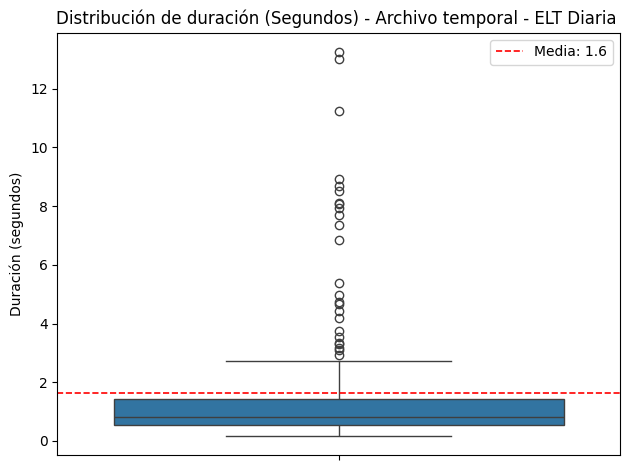

In [581]:
media = subset_debug_ETL_D_archivo_temporal['duracion'].mean()

sns.boxplot(data=subset_debug_ETL_D_archivo_temporal, y='duracion')
plt.axhline(media, color='red', linestyle='--', linewidth=1.2, label=f'Media: {media:.1f}')
plt.title('Distribución de duración (Segundos) - Archivo temporal - ELT Diaria ')
plt.ylabel('Duración (segundos)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Enriquecimiento Documento

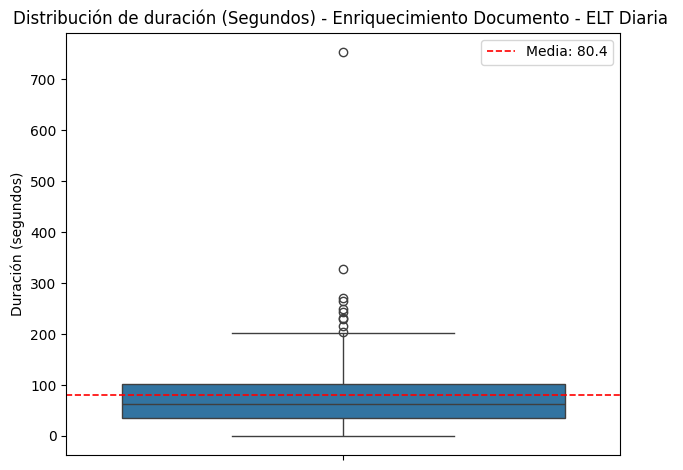

In [582]:
media_ed = subset_debug_ETL_D_enri_doc['duracion'].mean()

sns.boxplot(data=subset_debug_ETL_D_enri_doc, y='duracion')
plt.axhline(media_ed, color='red', linestyle='--', linewidth=1.2, label=f'Media: {media_ed:.1f}')
plt.title('Distribución de duración (Segundos) - Enriquecimiento Documento - ELT Diaria ')
plt.ylabel('Duración (segundos)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Chunking Documento enriquecido

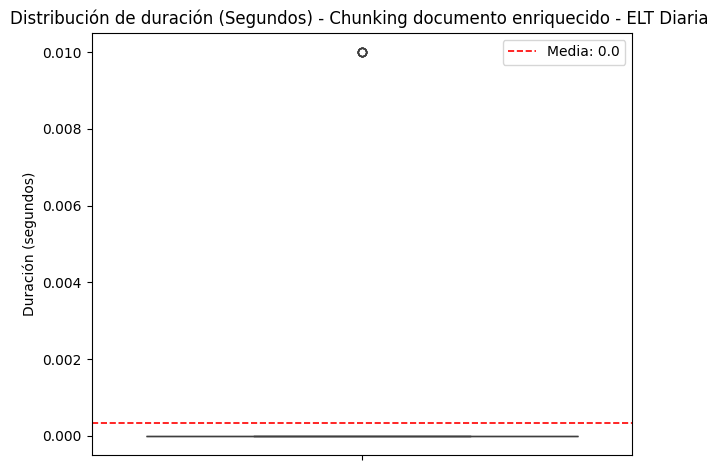

In [583]:
media_cde = subset_debug_ETL_D_chunking_enri_doc['duracion'].mean()

sns.boxplot(data=subset_debug_ETL_D_chunking_enri_doc, y='duracion')
plt.axhline(media_cde, color='red', linestyle='--', linewidth=1.2, label=f'Media: {media_cde:.1f}')
plt.title('Distribución de duración (Segundos) - Chunking documento enriquecido - ELT Diaria ')
plt.ylabel('Duración (segundos)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

#### Carga del Documento enriquecido en la BBDD

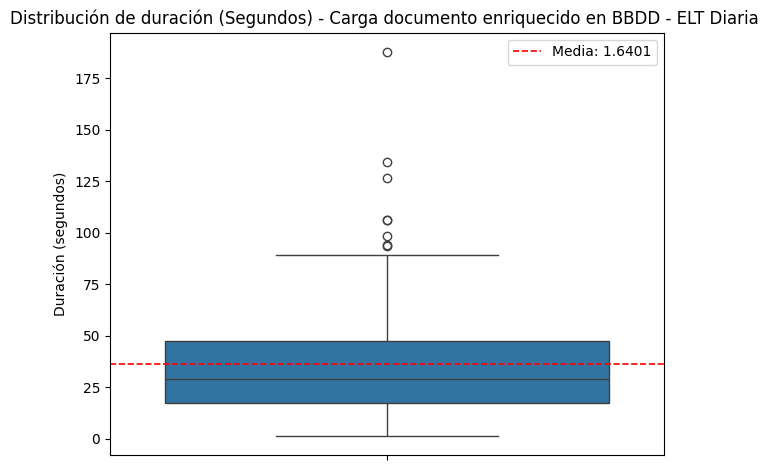

In [584]:
media_de_db = subset_debug_ETL_D_carga_db_enri_doc['duracion'].mean()

sns.boxplot(data=subset_debug_ETL_D_carga_db_enri_doc, y='duracion')
plt.title('Distribución de duración (Segundos) - Carga documento enriquecido en BBDD - ELT Diaria ')
plt.axhline(media_de_db, color='red', linestyle='--', linewidth=1.2, label=f'Media: {media:.4f}')
plt.ylabel('Duración (segundos)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Carga de chunks en la BBDD

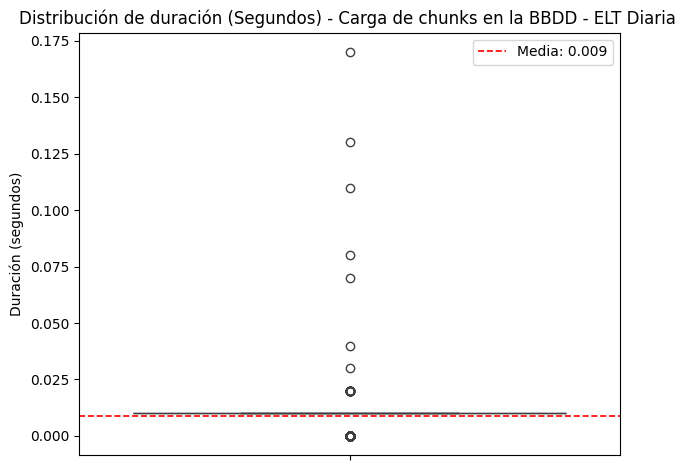

In [585]:
media_cc_db = subset_debug_ETL_D_carga_db_chunk['duracion'].mean()


sns.boxplot(data=subset_debug_ETL_D_carga_db_chunk, y='duracion')
plt.axhline(media_cc_db, color='red', linestyle='--', linewidth=1.2, label=f'Media: {media_cc_db:.3f}')
plt.title('Distribución de duración (Segundos) - Carga de chunks en la BBDD - ELT Diaria ')
plt.ylabel('Duración (segundos)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Carga del resumen en la BBDD

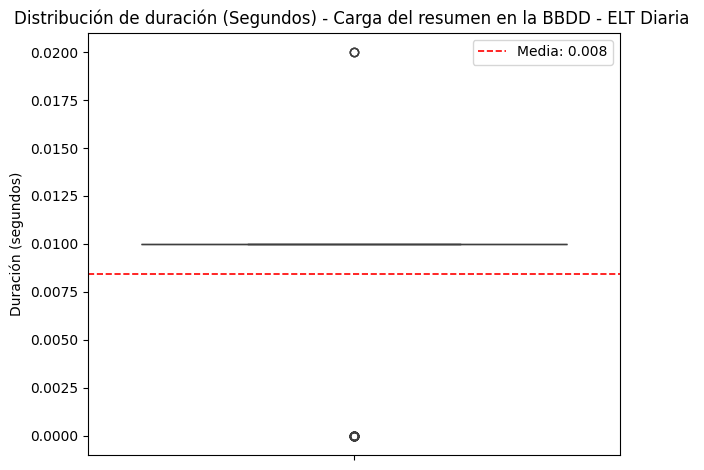

In [586]:
media_r_db = subset_debug_ETL_D_carga_db_resumen['duracion'].mean()

sns.boxplot(data=subset_debug_ETL_D_carga_db_resumen, y='duracion')
plt.axhline(media_r_db, color='red', linestyle='--', linewidth=1.2, label=f'Media: {media_r_db:.3f}')
plt.title('Distribución de duración (Segundos) - Carga del resumen en la BBDD - ELT Diaria ')
plt.ylabel('Duración (segundos)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

#### Totales por ETL ejecutada

In [587]:
subset_debug_ETL_D_totales.describe()

,publicaciones,chunks,embeddings,duracion
count,3.000000,3.000000,3.000000,3.000000
mean,52.000000,1396.333333,1448.333333,8590.613333
std,26.514147,673.012878,699.526507,4629.973105
min,26.000000,739.000000,765.000000,5151.680000
25%,38.500000,1052.500000,1091.000000,5958.385000
50%,51.000000,1366.000000,1417.000000,6765.090000
75%,65.000000,1725.000000,1790.000000,10310.080000
max,79.000000,2084.000000,2163.000000,13855.070000


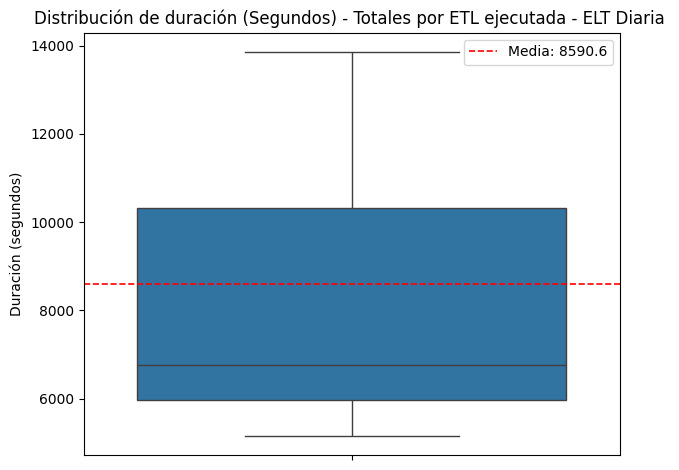

In [588]:
media_total = subset_debug_ETL_D_totales['duracion'].mean()

sns.boxplot(data=subset_debug_ETL_D_totales, y='duracion')
plt.axhline(media_total, color='red', linestyle='--', linewidth=1.2, label=f'Media: {media_total:.1f}')
plt.legend()
plt.title('Distribución de duración (Segundos) - Totales por ETL ejecutada - ELT Diaria ')
plt.ylabel('Duración (segundos)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Modelos

### Docling - OCR

In [589]:
DOCLING = pd.read_csv(DOCLING_LOG_PATH, delimiter='|')

In [590]:
DOCLING = DOCLING[DOCLING['level'] != 'INFO']

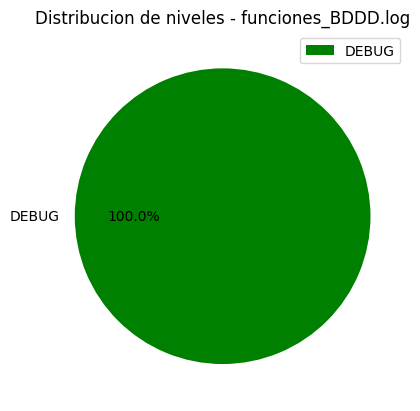

In [591]:
DOCLING['level'].value_counts().plot(
    kind='pie',
    autopct='%1.1f%%',
    colors=['green', 'red'], 
    ylabel=''
)
plt.title('Distribucion de niveles - funciones_BDDD.log')
plt.legend()
plt.show()

#### Generacion del Dataframe

In [592]:
timestamp = []
duracion = []
paginas = []

for row in DOCLING.itertuples():
    mensaje = row.message.split(',')    
    duracion.append(float(mensaje[0].split('-')[-1].strip()))
    paginas.append(int(mensaje[1].split('-')[-1].strip()))
    timestamp.append(datetime.strptime(row.timestamp, "%Y-%m-%d %H:%M:%S,%f"))

DOCLING_df = pd.DataFrame({

    'timestamp': timestamp,
    'duracion': duracion,
    'paginas': paginas

})

In [593]:
# Se redondea a segundos el TIMESTAMP para el JOIN
subset_debug_ETL_D_segmentacion['timestamp'] = subset_debug_ETL_D_segmentacion['timestamp'].dt.round('s')
DOCLING_df['timestamp'] = DOCLING_df['timestamp'].dt.round('s')
arxivid_to_merge_df = subset_debug_ETL_D_segmentacion[['timestamp','ID_arxiv']]

# JOIN PARA AGREGAR EL ID de ARXIV -- Tiene fines de facilitar la investigacion del archivo.
DOCLING_df_merged = pd.merge(DOCLING_df, arxivid_to_merge_df, on='timestamp', how='inner')


In [594]:
DOCLING_df_merged.head(1)

,timestamp,duracion,paginas,ID_arxiv
0,2025-05-18 15:52:53,26.16,24,2505.10551v1


#### Scatterplot - Duracion Vs Paginas

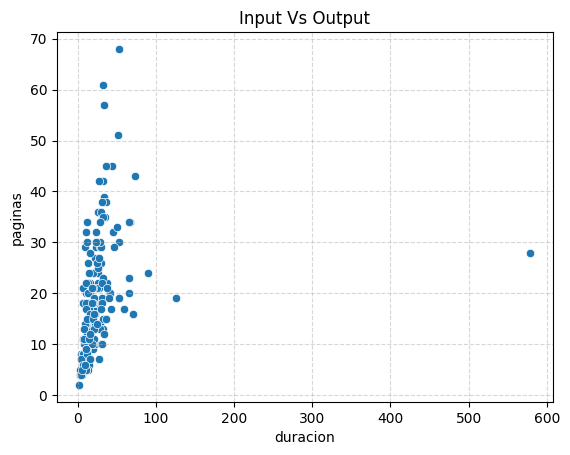

In [595]:
sns.scatterplot(data=DOCLING_df_merged, x='duracion', y='paginas')
plt.title('Input Vs Output')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

#### Boxplot - Duracion

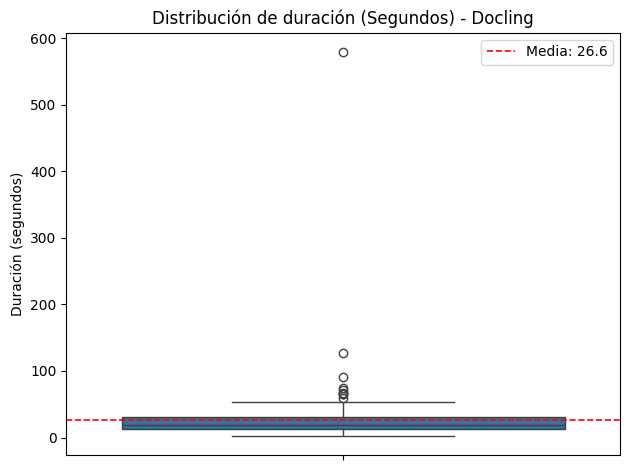

In [596]:
media_d = DOCLING_df_merged['duracion'].mean()

sns.boxplot(data=DOCLING_df_merged, y='duracion')
plt.axhline(media_d, color='red', linestyle='--', linewidth=1.2, label=f'Media: {media_d:.1f}')
plt.legend()
plt.title('Distribución de duración (Segundos) - Docling')
plt.ylabel('Duración (segundos)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Boxplot - Paginas

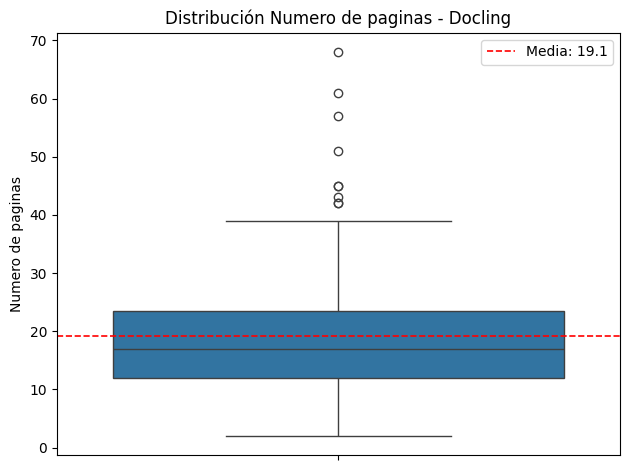

In [597]:
media_p = DOCLING_df_merged['paginas'].mean()

sns.boxplot(data=DOCLING_df_merged, y='paginas')
plt.axhline(media_p, color='red', linestyle='--', linewidth=1.2, label=f'Media: {media_p:.1f}')
plt.legend()
plt.title('Distribución Numero de paginas - Docling')
plt.ylabel('Numero de paginas')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Embedding Input usuario - BGEM3FlagModel

In [598]:
Embedding_USER_input = pd.read_csv(EMBEDDING_USER_LOG_PATH, delimiter='|')

In [599]:
Embedding_USER_input = Embedding_USER_input[Embedding_USER_input['level'] != 'INFO']

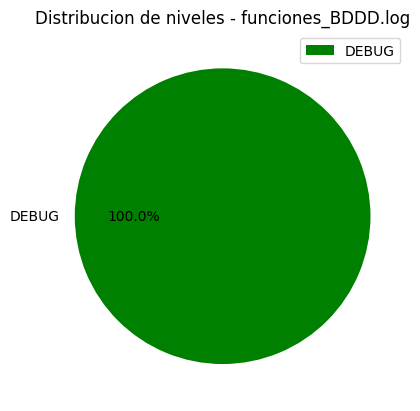

In [600]:
Embedding_USER_input['level'].value_counts().plot(
    kind='pie',
    autopct='%1.1f%%',
    colors=['green', 'red'], 
    ylabel=''
)
plt.title('Distribucion de niveles - funciones_BDDD.log')
plt.legend()
plt.show()

#### Generacion del dataframe

In [601]:
subset_debug_Embedding_USER = Embedding_USER_input[Embedding_USER_input['level'] == 'DEBUG']

In [602]:
timestamp = []
caracteres_text = []
input_tokens = []
duracion = []
long_embedding_denso = []
long_embedding_disperso = []


for row in subset_debug_Embedding_USER.itertuples():
    mensaje = row.message.split(',')    
    caracteres_text.append(int(mensaje[0].split('-')[-1].strip()))
    input_tokens.append(int(mensaje[1].split('-')[-1].strip()))
    duracion.append(float(mensaje[2].split('-')[-1].strip()))
    long_embedding_denso.append(int(mensaje[3].split('-')[-1].strip()))
    long_embedding_disperso.append(int(mensaje[4].split('-')[-1].strip()))

    timestamp.append(datetime.strptime(row.timestamp, "%Y-%m-%d %H:%M:%S,%f").date())

subset_debug_Embedding_USER_df = pd.DataFrame({

    'timestamp': timestamp,
    'duracion': duracion,
    'caracteres_text': caracteres_text,
    'input_tokens': input_tokens,
    'long_embedding_denso': long_embedding_denso,
    'long_embedding_disperso': long_embedding_disperso

})

#### Scatterplot - Duración Vs tokens de entrada

C:\Users\Usuario\AppData\Local\Temp\ipykernel_8212\2010911351.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


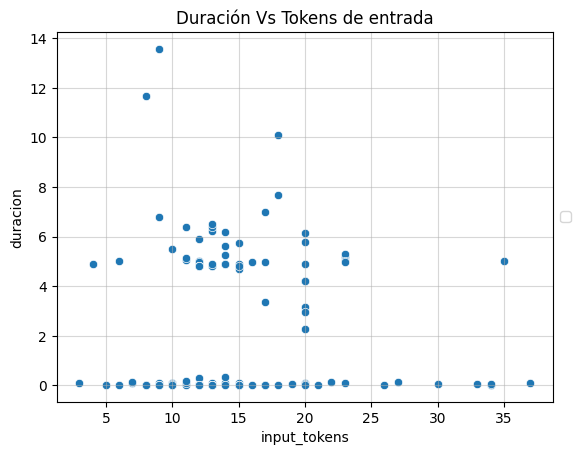

In [603]:
no_outliers = subset_debug_Embedding_USER_df[subset_debug_Embedding_USER_df['caracteres_text'] < 1000]
sns.scatterplot(data=no_outliers, x='input_tokens', y='duracion')
plt.title('Duración Vs Tokens de entrada')
plt.grid(True, linestyle='-', alpha=0.5)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

#### Boxplot - Duracion

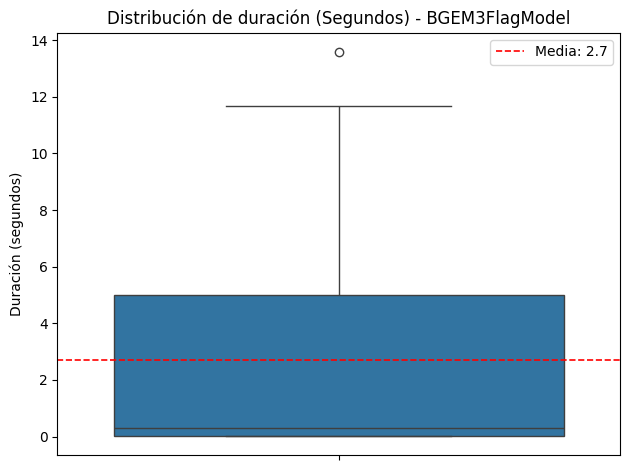

In [604]:
media_d = subset_debug_Embedding_USER_df['duracion'].mean()

sns.boxplot(data=subset_debug_Embedding_USER_df, y='duracion')
plt.axhline(media_d, color='red', linestyle='--', linewidth=1.2, label=f'Media: {media_d:.1f}')
plt.legend()
plt.title('Distribución de duración (Segundos) - BGEM3FlagModel')
plt.ylabel('Duración (segundos)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Boxplot - Caracteres Text

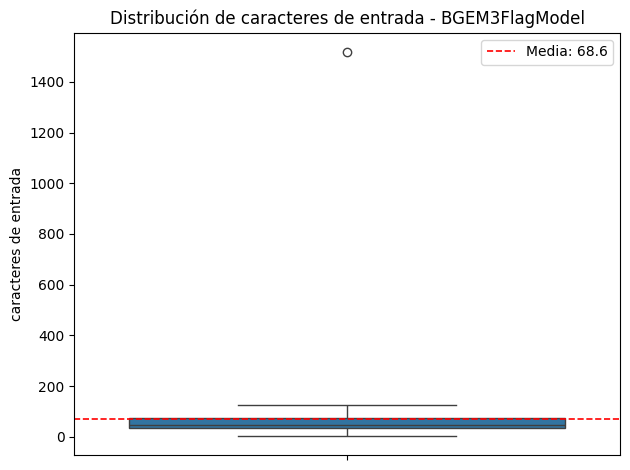

In [605]:
media_ct = subset_debug_Embedding_USER_df['caracteres_text'].mean()

sns.boxplot(data=subset_debug_Embedding_USER_df, y='caracteres_text')
plt.axhline(media_ct, color='red', linestyle='--', linewidth=1.2, label=f'Media: {media_ct:.1f}')
plt.legend()
plt.title('Distribución de caracteres de entrada - BGEM3FlagModel')
plt.ylabel('caracteres de entrada')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Histograma -  Caracteres text

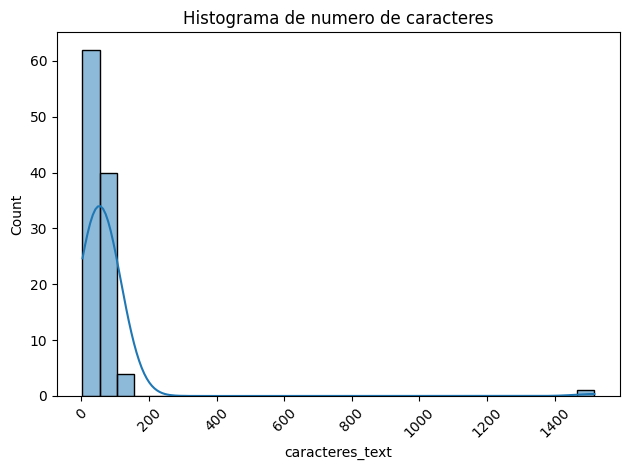

In [606]:
sns.histplot(data=subset_debug_Embedding_USER_df, x='caracteres_text', bins=30, kde=True)
plt.title('Histograma de numero de caracteres')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Boxplot - Input tokens

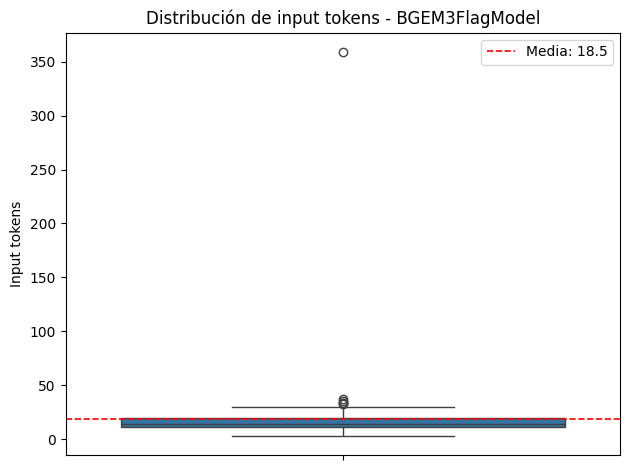

In [607]:
media_it = subset_debug_Embedding_USER_df['input_tokens'].mean()

sns.boxplot(data=subset_debug_Embedding_USER_df, y='input_tokens')
plt.axhline(media_it, color='red', linestyle='--', linewidth=1.2, label=f'Media: {media_it:.1f}')
plt.legend()
plt.title('Distribución de input tokens - BGEM3FlagModel')
plt.ylabel('Input tokens')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Boxplot - Longitud embedding disperso

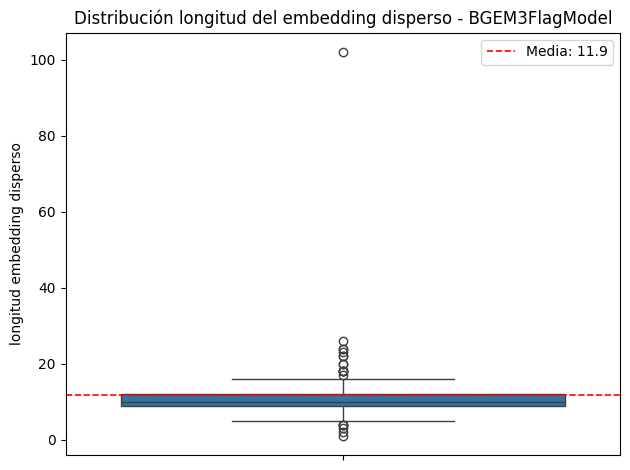

In [608]:
media_led = subset_debug_Embedding_USER_df['long_embedding_disperso'].mean()

sns.boxplot(data=subset_debug_Embedding_USER_df, y='long_embedding_disperso')
plt.axhline(media_led, color='red', linestyle='--', linewidth=1.2, label=f'Media: {media_led:.1f}')
plt.legend()
plt.title('Distribución longitud del embedding disperso - BGEM3FlagModel')
plt.ylabel('longitud embedding disperso')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Conteo - Longitud embedding denso (Ha de ser siempre igual)

In [609]:
subset_debug_Embedding_USER_df['long_embedding_denso'].value_counts().reset_index()

,long_embedding_denso,count
0,1024,107


### Embedding Resumen - BGEM3FlagModel

In [610]:
Embedding_RESUMEN = pd.read_csv(EMBEDDING_RESUMEN_LOG_PATH, delimiter='|')

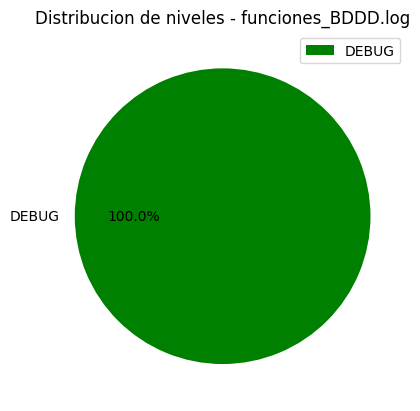

In [611]:
Embedding_RESUMEN['level'].value_counts().plot(
    kind='pie',
    autopct='%1.1f%%',
    colors=['green', 'red'], 
    ylabel=''
)
plt.title('Distribucion de niveles - funciones_BDDD.log')
plt.legend()
plt.show()

#### Generacion del dataframe

In [612]:
subset_debug_Embedding_RESUMEN = Embedding_RESUMEN[Embedding_RESUMEN['level'] == 'DEBUG']

In [613]:
timestamp = []
caracteres_text = []
input_tokens = []
duracion = []
long_embedding_denso = []
long_embedding_disperso = []
id_arxiv = []

for row in subset_debug_Embedding_RESUMEN.itertuples():
    mensaje = row.message.split(',')    
    caracteres_text.append(int(mensaje[0].split('-')[-1].strip()))
    input_tokens.append(int(mensaje[1].split('-')[-1].strip()))
    duracion.append(float(mensaje[2].split('-')[-1].strip()))
    long_embedding_denso.append(int(mensaje[3].split('-')[-1].strip()))
    long_embedding_disperso.append(int(mensaje[4].split('-')[-1].strip()))
    id_arxiv.append(mensaje[5].split('-')[-1].strip())

    timestamp.append(datetime.strptime(row.timestamp, "%Y-%m-%d %H:%M:%S,%f").date())

subset_debug_Embedding_RESUMEN_df = pd.DataFrame({

    'timestamp': timestamp,
    'duracion': duracion,
    'caracteres_text': caracteres_text,
    'input_tokens': input_tokens,
    'long_embedding_denso': long_embedding_denso,
    'long_embedding_disperso': long_embedding_disperso,
    'id_arxiv': id_arxiv,

})

#### Boxplot - Duracion

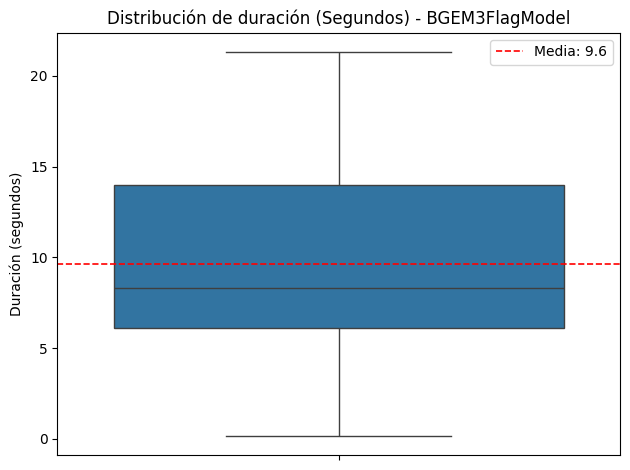

In [614]:
media_d = subset_debug_Embedding_RESUMEN_df['duracion'].mean()

sns.boxplot(data=subset_debug_Embedding_RESUMEN_df, y='duracion')
plt.axhline(media_d, color='red', linestyle='--', linewidth=1.2, label=f'Media: {media_d:.1f}')
plt.legend()
plt.title('Distribución de duración (Segundos) - BGEM3FlagModel')
plt.ylabel('Duración (segundos)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Boxplot - Caracteres Text

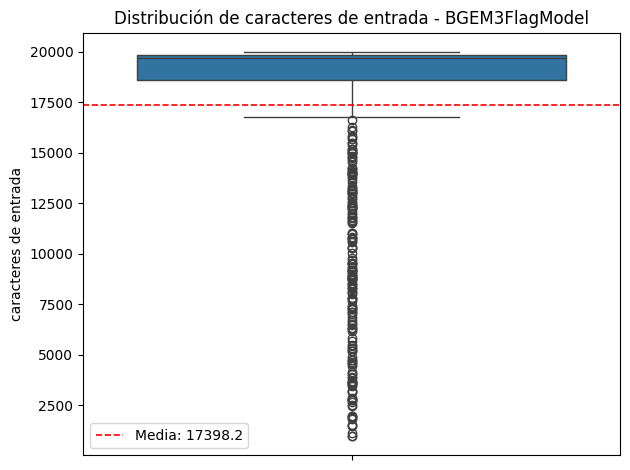

In [615]:
media_ct = subset_debug_Embedding_RESUMEN_df['caracteres_text'].mean()

sns.boxplot(data=subset_debug_Embedding_RESUMEN_df, y='caracteres_text')
plt.axhline(media_ct, color='red', linestyle='--', linewidth=1.2, label=f'Media: {media_ct:.1f}')
plt.legend()
plt.title('Distribución de caracteres de entrada - BGEM3FlagModel')
plt.ylabel('caracteres de entrada')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Histograma - Carateres Text

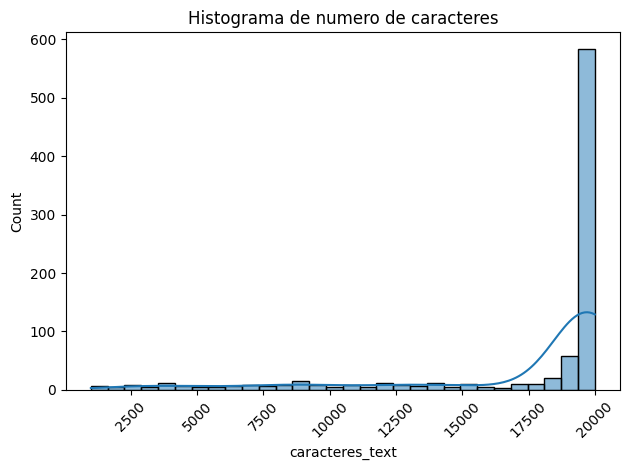

In [616]:
sns.histplot(data=subset_debug_Embedding_RESUMEN_df, x='caracteres_text', bins=30, kde=True)
plt.title('Histograma de numero de caracteres')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Boxplot - Input tokens

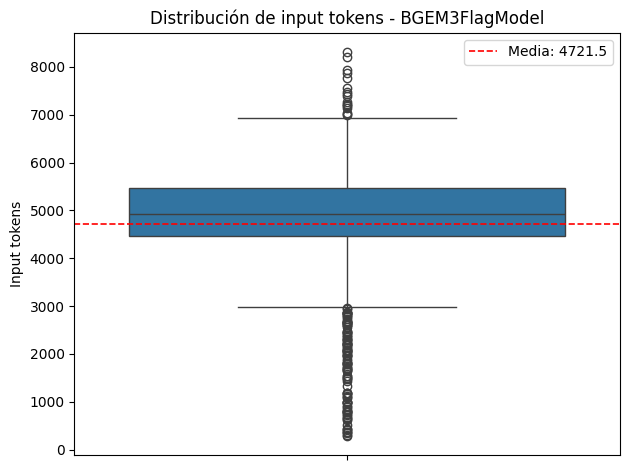

In [617]:
media_it = subset_debug_Embedding_RESUMEN_df['input_tokens'].mean()

sns.boxplot(data=subset_debug_Embedding_RESUMEN_df, y='input_tokens')
plt.axhline(media_it, color='red', linestyle='--', linewidth=1.2, label=f'Media: {media_it:.1f}')
plt.legend()
plt.title('Distribución de input tokens - BGEM3FlagModel')
plt.ylabel('Input tokens')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Boxplot - Longitud embedding disperso

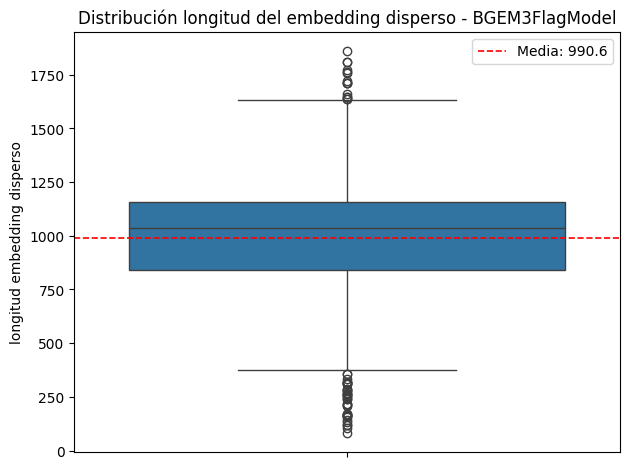

In [618]:
media_led = subset_debug_Embedding_RESUMEN_df['long_embedding_disperso'].mean()

sns.boxplot(data=subset_debug_Embedding_RESUMEN_df, y='long_embedding_disperso')
plt.axhline(media_led, color='red', linestyle='--', linewidth=1.2, label=f'Media: {media_led:.1f}')
plt.legend()
plt.title('Distribución longitud del embedding disperso - BGEM3FlagModel')
plt.ylabel('longitud embedding disperso')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Conteo - Longitud embedding denso (ha de ser siempre igual)

In [619]:
subset_debug_Embedding_RESUMEN_df['long_embedding_denso'].value_counts().reset_index()

,long_embedding_denso,count
0,1024,865


### Embedding Chunk - BGEM3FlagModel

In [620]:
Embedding_CHUNK = pd.read_csv(EMBEDDING_CHUNK_LOG_PATH, delimiter='|')

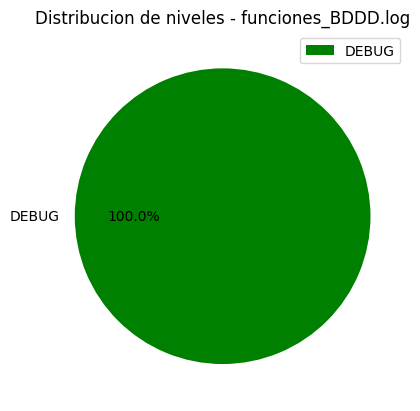

In [621]:
Embedding_CHUNK['level'].value_counts().plot(
    kind='pie',
    autopct='%1.1f%%',
    colors=['green', 'red'], 
    ylabel=''
)
plt.title('Distribucion de niveles - funciones_BDDD.log')
plt.legend()
plt.show()

#### Generacion del dataframe

In [622]:
subset_debug_Embedding_CHUNK = Embedding_CHUNK[Embedding_CHUNK['level'] == 'DEBUG']

In [623]:
timestamp = []
caracteres_text = []
input_tokens = []
duracion = []
long_embedding_denso = []
long_embedding_disperso = []
similitud_coseno = []
id_arxiv = []

for row in subset_debug_Embedding_CHUNK.itertuples():
    mensaje = row.message.split(',')    
    caracteres_text.append(int(mensaje[0].split('-')[-1].strip()))
    input_tokens.append(int(mensaje[1].split('-')[-1].strip()))
    duracion.append(float(mensaje[2].split('-')[-1].strip()))
    long_embedding_denso.append(int(mensaje[3].split('-')[-1].strip()))
    long_embedding_disperso.append(int(mensaje[4].split('-')[-1].strip()))
    similitud_coseno.append(float(mensaje[5].split('-')[-1].strip()))
    id_arxiv.append(mensaje[6].split('-')[-1].strip())

    timestamp.append(datetime.strptime(row.timestamp, "%Y-%m-%d %H:%M:%S,%f").date())

subset_debug_Embedding_CHUNK_df = pd.DataFrame({

    'timestamp': timestamp,
    'duracion': duracion,
    'caracteres_text': caracteres_text,
    'input_tokens': input_tokens,
    'long_embedding_denso': long_embedding_denso,
    'long_embedding_disperso': long_embedding_disperso,
    'similitud_coseno': similitud_coseno,
    'id_arxiv': id_arxiv,

})


In [624]:
subset_debug_Embedding_CHUNK_df.head()

,timestamp,duracion,caracteres_text,input_tokens,long_embedding_denso,long_embedding_disperso,similitud_coseno,id_arxiv
0,2025-05-17,0.47,2029,484,1024,178,0.766673,2505.10559v1
1,2025-05-17,0.82,2966,708,1024,268,0.781256,2505.10559v1
2,2025-05-17,0.83,2950,723,1024,256,0.800813,2505.10559v1
3,2025-05-17,1.00,2932,809,1024,176,0.778962,2505.10559v1
4,2025-05-17,0.82,2257,703,1024,197,0.792736,2505.10559v1


#### Boxplot - Duracion

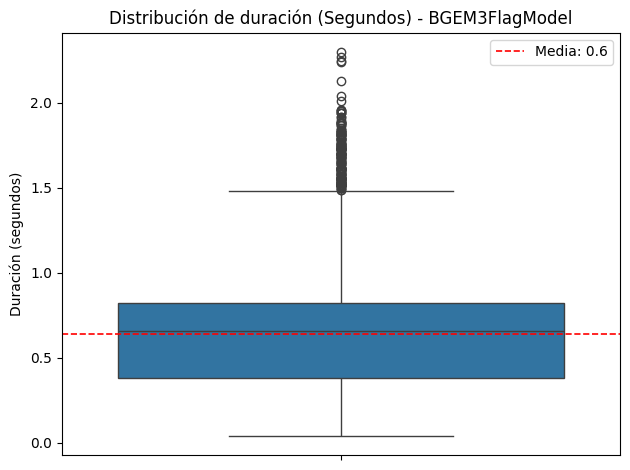

In [625]:
media_d = subset_debug_Embedding_CHUNK_df['duracion'].mean()

sns.boxplot(data=subset_debug_Embedding_CHUNK_df, y='duracion')
plt.axhline(media_d, color='red', linestyle='--', linewidth=1.2, label=f'Media: {media_d:.1f}')
plt.legend()
plt.title('Distribución de duración (Segundos) - BGEM3FlagModel')
plt.ylabel('Duración (segundos)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Boxplot - Caracteres Text

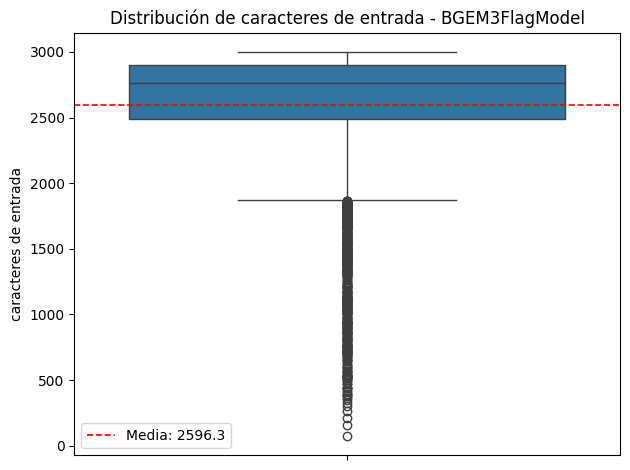

In [626]:
media_ct = subset_debug_Embedding_CHUNK_df['caracteres_text'].mean()

sns.boxplot(data=subset_debug_Embedding_CHUNK_df, y='caracteres_text')
plt.axhline(media_ct, color='red', linestyle='--', linewidth=1.2, label=f'Media: {media_ct:.1f}')
plt.legend()
plt.title('Distribución de caracteres de entrada - BGEM3FlagModel')
plt.ylabel('caracteres de entrada')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Histograma - Carateres Text

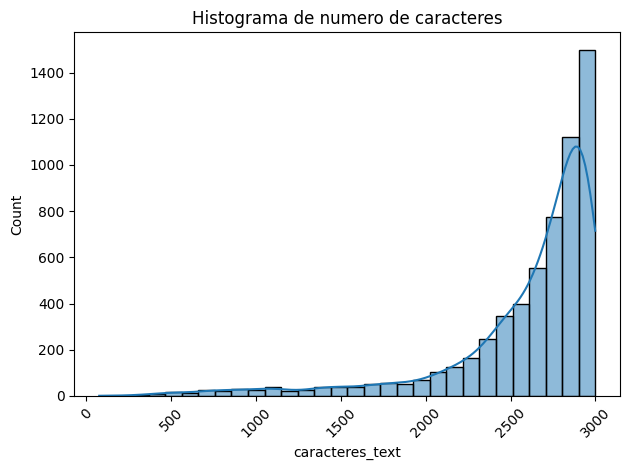

In [627]:
sns.histplot(data=subset_debug_Embedding_CHUNK_df, x='caracteres_text', bins=30, kde=True)
plt.title('Histograma de numero de caracteres')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Boxplot - Input tokens

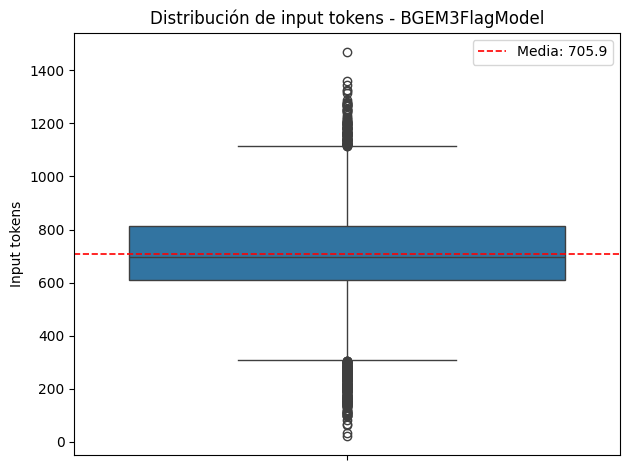

In [628]:
media_it = subset_debug_Embedding_CHUNK_df['input_tokens'].mean()

sns.boxplot(data=subset_debug_Embedding_CHUNK_df, y='input_tokens')
plt.axhline(media_it, color='red', linestyle='--', linewidth=1.2, label=f'Media: {media_it:.1f}')
plt.legend()
plt.title('Distribución de input tokens - BGEM3FlagModel')
plt.ylabel('Input tokens')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Boxplot - Longitud embedding disperso

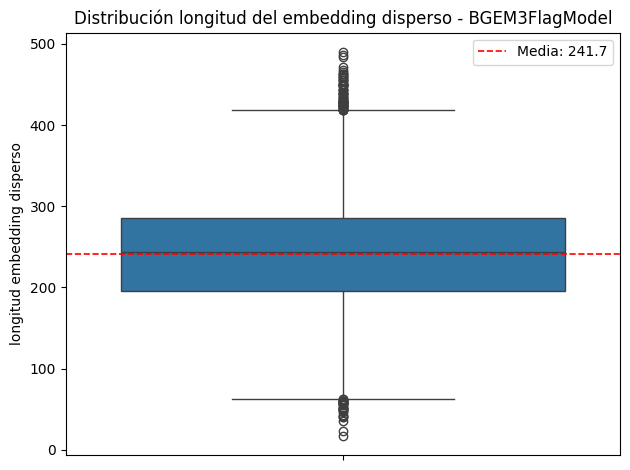

In [629]:
media_led = subset_debug_Embedding_CHUNK_df['long_embedding_disperso'].mean()

sns.boxplot(data=subset_debug_Embedding_CHUNK_df, y='long_embedding_disperso')
plt.axhline(media_led, color='red', linestyle='--', linewidth=1.2, label=f'Media: {media_led:.1f}')
plt.legend()
plt.title('Distribución longitud del embedding disperso - BGEM3FlagModel')
plt.ylabel('longitud embedding disperso')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Conteo - Longitud embedding denso (ha de ser siempre igual)

In [630]:
subset_debug_Embedding_CHUNK_df['long_embedding_denso'].value_counts().reset_index()

,long_embedding_denso,count
0,1024,5918


Dado que es un modelo que su salida siempre es la misma, se utiliza el DF para su visualizacion, clara y directa. Todo valor que no sea 1024, sera un valor anomalo en caso de que no se haya cambiado el modelo.

#### Boxplot - Simlitud del Coseno

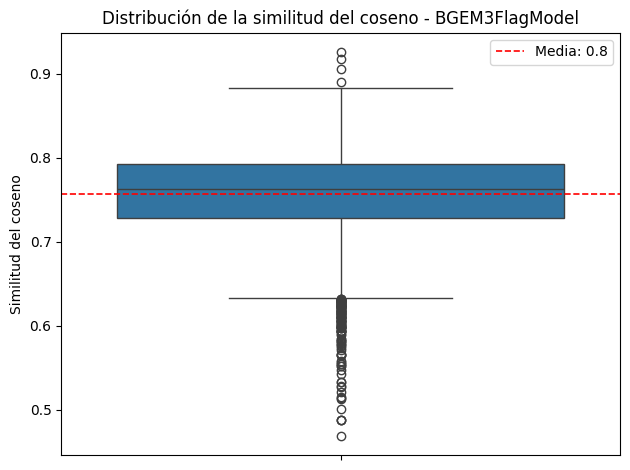

In [631]:
media_sc = subset_debug_Embedding_CHUNK_df['similitud_coseno'].mean()


sns.boxplot(data=subset_debug_Embedding_CHUNK_df, y='similitud_coseno')
plt.axhline(media_sc, color='red', linestyle='--', linewidth=1.2, label=f'Media: {media_sc:.1f}')
plt.legend()
plt.title('Distribución de la similitud del coseno - BGEM3FlagModel')
plt.ylabel('Similitud del coseno')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Florence 2 - Anotacion de imagenes

In [632]:
F2_df = pd.read_csv(FLORENCE2_LOG_PATH, delimiter='|')
F2_df = F2_df[F2_df['level'] != 'INFO']

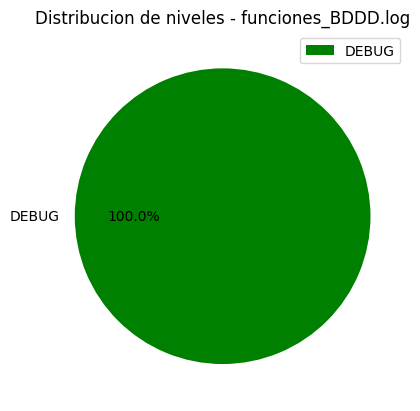

In [633]:
F2_df['level'].value_counts().plot(
    kind='pie',
    autopct='%1.1f%%',
    colors=['green', 'red'], 
    ylabel=''
)
plt.title('Distribucion de niveles - funciones_BDDD.log')
plt.legend()
plt.show()

#### Generacion del dataframe

In [634]:
subset_debug_F2 = F2_df[F2_df['level'] == 'DEBUG']

In [635]:
timestamp = []
alto_imagen = []
ancho_imagen = []
char_generados = []
duracion_F2 = []

for row in subset_debug_F2.itertuples():
    mensaje = row.message.split(',')

    duracion_F2.append(float(mensaje[0].split('-')[-1].strip()))
    char_generados.append(int(mensaje[1].split('-')[-1].strip()))
    alto_imagen.append(int(mensaje[2].split('-')[-1].strip()))
    ancho_imagen.append(int(mensaje[3].split('-')[-1].strip()))
    timestamp.append(datetime.strptime(row.timestamp, "%Y-%m-%d %H:%M:%S,%f").date())


subset_debug_F2 = pd.DataFrame({
    'timestamp': timestamp,
    'duracion': duracion_F2,
    'char_generados': char_generados,
    'alto_imagen': alto_imagen,
    'ancho_imagen': ancho_imagen,

})
# Area de la imagen para contrastarlo con la duracion
subset_debug_F2['area_total'] = subset_debug_F2['alto_imagen'] * subset_debug_F2['ancho_imagen']

#### Boxplot - Distribucion duracion

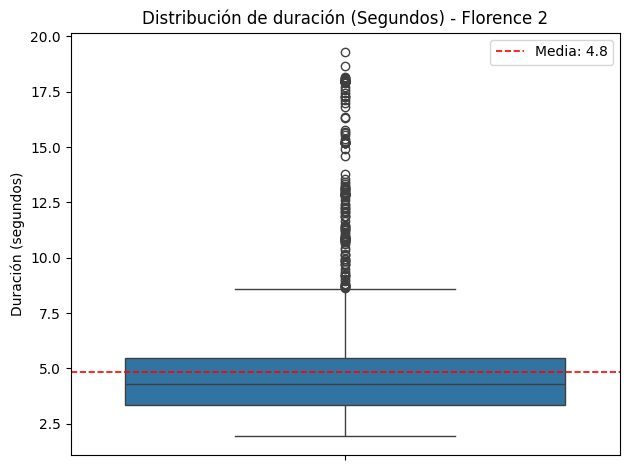

In [636]:
media_dd = subset_debug_F2['duracion'].mean()

sns.boxplot(data=subset_debug_F2, y='duracion')
plt.axhline(media_dd, color='red', linestyle='--', linewidth=1.2, label=f'Media: {media_dd:.1f}')
plt.legend()
plt.title('Distribución de duración (Segundos) - Florence 2')
plt.ylabel('Duración (segundos)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Boxplot - Distribucion generacion caracteres

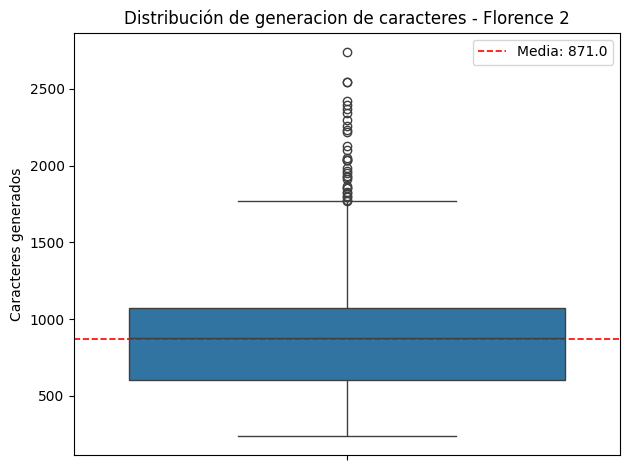

In [637]:
media_dgc = subset_debug_F2['char_generados'].mean()

sns.boxplot(data=subset_debug_F2, y='char_generados')
plt.axhline(media_dgc, color='red', linestyle='--', linewidth=1.2, label=f'Media: {media_dgc:.1f}')
plt.legend()
plt.title('Distribución de generacion de caracteres - Florence 2')
plt.ylabel('Caracteres generados')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Scatterplot - Area total Vs Duracion

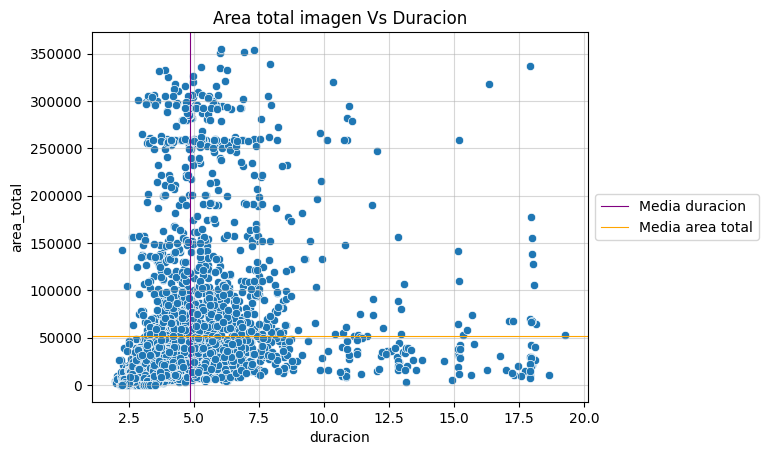

In [638]:
duracion_media_F2 = subset_debug_F2['duracion'].mean()
area_media_F2 = subset_debug_F2['area_total'].mean()
sns.scatterplot(data=subset_debug_F2, x='duracion', y='area_total')
plt.title('Area total imagen Vs Duracion')
plt.axvline(duracion_media_F2, color='purple', linestyle='-', linewidth=0.8, label='Media duracion')
plt.axhline(area_media_F2, color='orange', linestyle='-', linewidth=0.8, label='Media area total')
plt.grid(True, linestyle='-', alpha=0.5)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [ ]:
subset_debug_F2[['duracion','area_total']].corr()

#### Scatterplot Area Total Vs Caracteres Generados

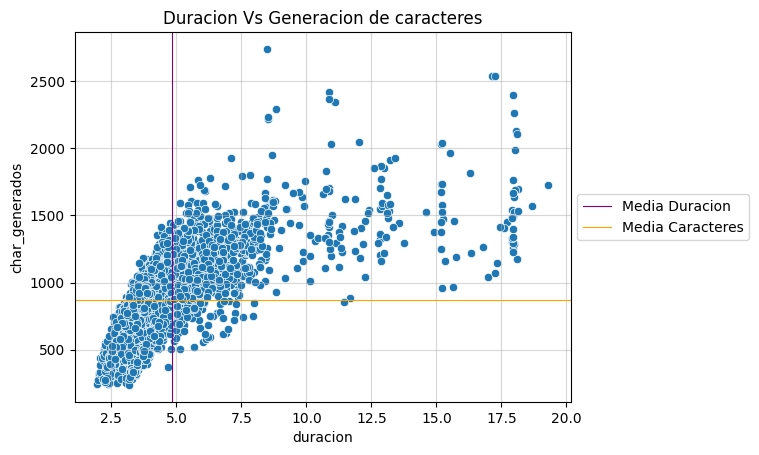

In [697]:
caracter_media_F2 = subset_debug_F2['char_generados'].mean()
sns.scatterplot(data=subset_debug_F2, x='duracion', y='char_generados')
plt.title('Duracion Vs Generacion de caracteres')
plt.axvline(duracion_media_F2, color='purple', linestyle='-', linewidth=0.8, label='Media Duracion')
plt.axhline(caracter_media_F2, color='orange', linestyle='-', linewidth=0.8, label='Media Caracteres')
plt.grid(True, linestyle='-', alpha=0.5)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [690]:
subset_debug_F2[['duracion','char_generados']].corr()

,duracion,char_generados
duracion,1.000000,0.710128
char_generados,0.710128,1.000000


### Funciones BBDD -  Coseno de similitud

In [639]:
coseno_similitud_df = pd.read_csv(FUNCIONES_BBDD_LOG_PATH, delimiter='|')

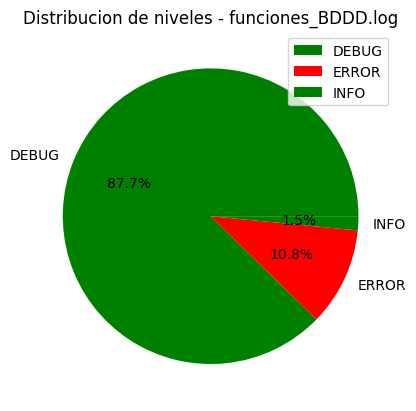

In [640]:
coseno_similitud_df['level'].value_counts().plot(
    kind='pie',
    autopct='%1.1f%%',
    colors=['green', 'red'], 
    ylabel=''
)
plt.title('Distribucion de niveles - funciones_BDDD.log')
plt.legend()
plt.show()

#### Generacion del dataframe

In [641]:
subset_debug_coseno_similitud = coseno_similitud_df[coseno_similitud_df['level'] == 'DEBUG']

In [642]:
timestamp = []
categoria = []
umbral_similitud = []
docs_recuperados = []

for row in subset_debug_coseno_similitud.itertuples():
    mensaje = row.message

    if 'Consultando BBDD chunks' in mensaje:
        
        try:
            split_message = mensaje.split(',')
            umbral_similitud.append(float(split_message[0].strip().split('-')[-1]))
            categoria.append('chunks')
            docs_recuperados.append(int(split_message[1].strip().split('-')[-1]))
            timestamp.append(datetime.strptime(row.timestamp, "%Y-%m-%d %H:%M:%S,%f").date())
        except Exception as e:
            print(f"Error parsing métricas: {mensaje} | {e}")

    elif 'Consultando BBDD resumenes' in mensaje:

        try:
            split_message = mensaje.split(',')

            umbral_similitud.append(float(split_message[0].strip().split('-')[-1]))
            categoria.append('resumenes')
            docs_recuperados.append(int(split_message[1].strip().split('-')[-1]))
            timestamp.append(datetime.strptime(row.timestamp, "%Y-%m-%d %H:%M:%S,%f").date())
        except Exception as e:
            print(f"Error parsing métricas: {mensaje} | {e}")
    

subset_debug_coseno_similitud_df= pd.DataFrame({
    'timestamp': timestamp,
    'categoria': categoria,
    'umbral_similitud': umbral_similitud,
    'docs_recuperados': docs_recuperados
})

#### Barplot - Documentos recuperados por tipo

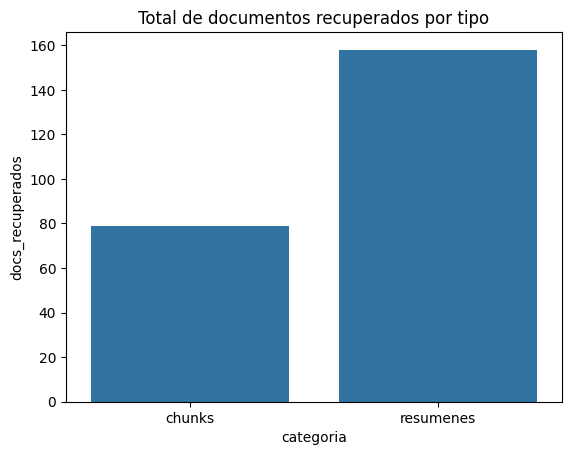

In [643]:
sns.barplot(data=subset_debug_coseno_similitud_df.groupby(['categoria'])['docs_recuperados'].sum().reset_index(), x='categoria', y='docs_recuperados')
plt.title('Total de documentos recuperados por tipo')
plt.show()

In [644]:
subset_debug_coseno_similitud_df.groupby(['categoria'])['docs_recuperados'].sum().reset_index()

,categoria,docs_recuperados
0,chunks,79
1,resumenes,158


### LLM - Llama 3.1 - Intencionalidad

In [645]:
llm_intencion_df = pd.read_csv(LLM_INTENCION_LOG_PATH, delimiter='|')

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xbf in position 43881: invalid start byte

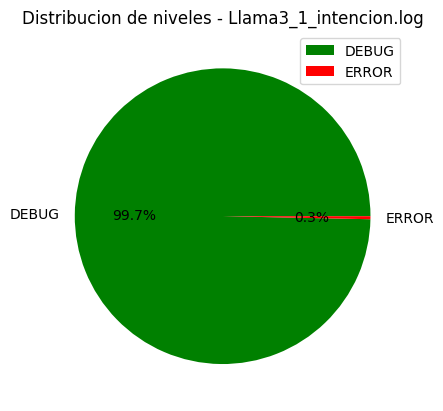

In [ ]:
llm_intencion_df['level'].value_counts().plot(
    kind='pie',
    autopct='%1.1f%%',
    colors=['green', 'red'],  
    ylabel='' 
)
plt.title('Distribucion de niveles - Llama3_1_intencion.log')
plt.legend()
plt.show()

#### Generacion del dataframe

In [ ]:
subset_debug_llm_intencion = llm_intencion_df[llm_intencion_df['level'] == 'DEBUG']

In [ ]:
timestamp = []
tokens_entrada_inten = []
tokens_generados_inten = []
duracion_inten = []
intencion_hablar = 0
intencion_consultar = 0

for row in subset_debug_llm_intencion.itertuples():
    mensaje = row.message

    if 'Tokens de entrada' in mensaje:
        try:
            split_message = mensaje.split(',')

            token_entrada = split_message[0].split('-')[-1].strip()
            token_generados = split_message[1].split('-')[-1].strip()
            duracion_seg = split_message[2].split('-')[-1].strip()

            t_entrada = int(token_entrada)
            t_generados = int(token_generados)
            d_segundos = float(duracion_seg)

            tokens_entrada_inten.append(t_entrada)
            tokens_generados_inten.append(t_generados)
            duracion_inten.append(d_segundos)
            timestamp.append(datetime.strptime(row.timestamp, "%Y-%m-%d %H:%M:%S,%f").date())
        except Exception as e:
            print(f"Error parsing métricas: {mensaje} | {e}")
    if 'hablar' in mensaje:
        intencion_hablar += 1
    if 'consultar' in mensaje:
        intencion_consultar += 1
    

subset_debug_llm_intencion_df_numeric = pd.DataFrame({
    'timestamp': timestamp,
    'tokens_entrada': tokens_entrada_inten,
    'tokens_generados': tokens_generados_inten,
    'duracion': duracion_inten
})



#### Conteo categorias de intencionalidad

In [ ]:
print(f'Numero de intenciones de hablar: {intencion_hablar}')
print(f'Numero de intenciones de consultar: {intencion_consultar}')

Numero de intenciones de hablar: 45
Numero de intenciones de consultar: 106


#### Histograma - Tokens entrada

C:\Users\Usuario\AppData\Local\Temp\ipykernel_8212\3307211049.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


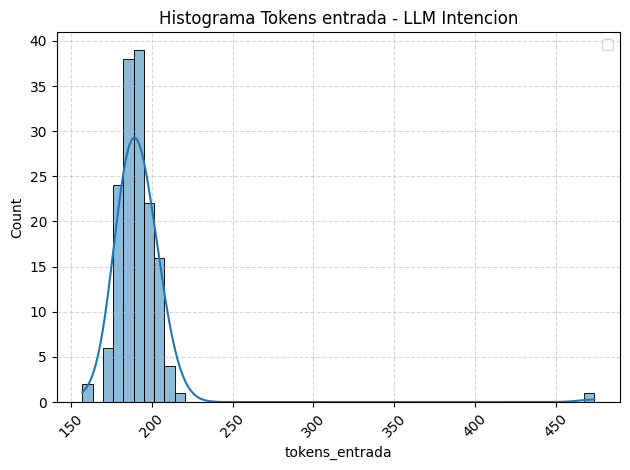

In [ ]:
sns.histplot(data=subset_debug_llm_intencion_df_numeric, x='tokens_entrada', bins=50, kde=True)
plt.title('Histograma Tokens entrada - LLM Intencion')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

#### Scatterplot - Tokens entrada Vs Duración

In [ ]:
sns.scatterplot(data=subset_debug_llm_intencion_df_numeric, x='Caracteres_input', y='Caracteres_output')
plt.title('Input Vs Output')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

#### Boxplot - Tokens entrada

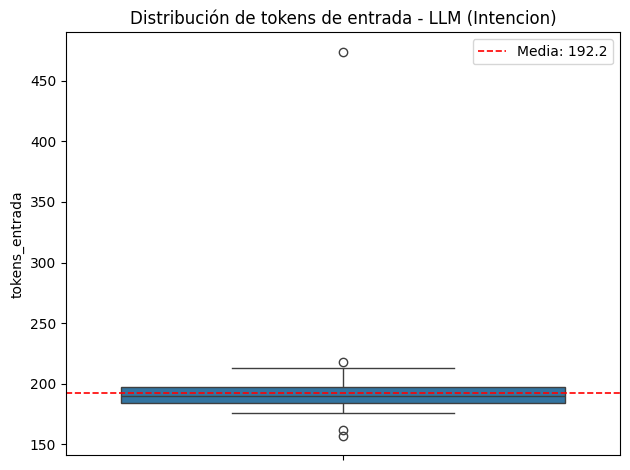

In [ ]:
media_te = subset_debug_llm_intencion_df_numeric['tokens_entrada'].mean()
sns.boxplot(data=subset_debug_llm_intencion_df_numeric, y='tokens_entrada')
plt.axhline(media_te, color='red', linestyle='--', linewidth=1.2, label=f'Media: {media_te:.1f}')
plt.legend()
plt.title('Distribución de tokens de entrada - LLM (Intencion)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Boxplot - Distribucion duracion

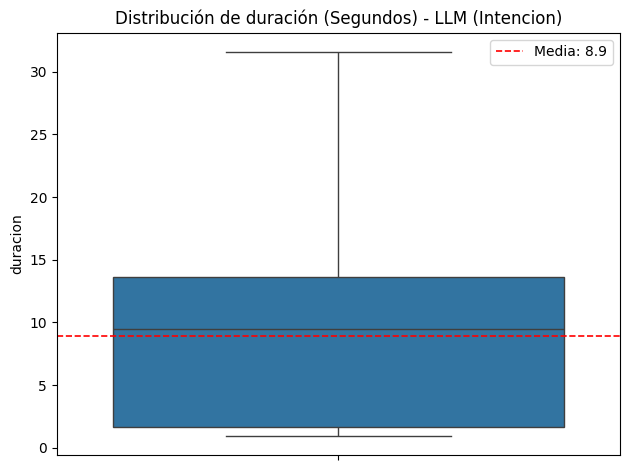

In [ ]:
media_ddur = subset_debug_llm_intencion_df_numeric['duracion'].mean()

sns.boxplot(data=subset_debug_llm_intencion_df_numeric, y='duracion')
plt.axhline(media_ddur, color='red', linestyle='--', linewidth=1.2, label=f'Media: {media_ddur:.1f}')
plt.legend()
plt.title('Distribución de duración (Segundos) - LLM (Intencion)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### LLM - Llama 3.1

In [ ]:
llm_df = pd.read_csv(LLM_LOG_PATH, delimiter='|')

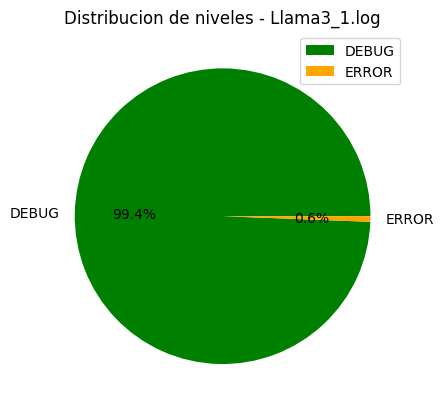

In [ ]:
llm_df['level'].value_counts().plot(
    kind='pie',
    autopct='%1.1f%%',
    colors=['green', 'orange', 'red'],  
    ylabel=''  
)
plt.title('Distribucion de niveles - Llama3_1.log')
plt.legend()
plt.show()

#### Generacion del dataframe

In [ ]:
subset_debug_llm = llm_df[llm_df['level'] == 'DEBUG']

In [ ]:
timestamp = []
tokens_entrada = []
tokens_generados = []
duracion = []
token_segundo = []

for row in subset_debug_llm.itertuples():
    timestamp.append(datetime.strptime(row.timestamp, "%Y-%m-%d %H:%M:%S,%f").date())
    split_message = row.message.split(',')
    tokens_entrada.append(int(split_message[0].split('-')[1].strip()))
    tokens_generados.append(int(split_message[1].split('-')[1].strip()))
    duracion.append(float(split_message[2].split('-')[1].strip()))
    token_segundo.append(float(split_message[3].split('-')[1].strip()))

subset_debug_llm_df = pd.DataFrame({
    'timestamp': timestamp,
    'tokens_entrada':tokens_entrada,
    'tokens_generados': tokens_generados,
    'duracion':duracion,
    'token_segundo':token_segundo
})


#### Histograma - Tokens de entrada

C:\Users\Usuario\AppData\Local\Temp\ipykernel_8212\2544677773.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


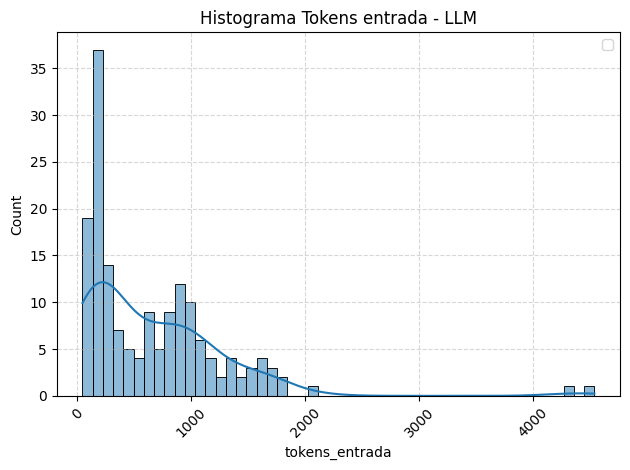

In [ ]:
sns.histplot(data=subset_debug_llm_df, x='tokens_entrada', bins=50, kde=True)
plt.title('Histograma Tokens entrada - LLM')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

#### Boxplot - Token Entrada

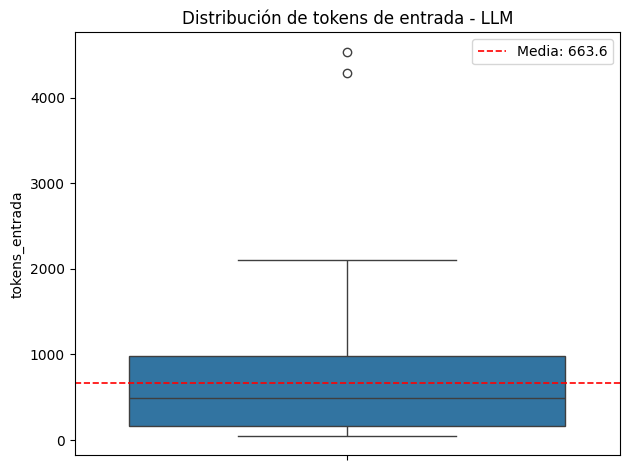

In [ ]:
media_te = subset_debug_llm_df['tokens_entrada'].mean()

sns.boxplot(data=subset_debug_llm_df, y='tokens_entrada')
plt.axhline(media_te, color='red', linestyle='--', linewidth=1.2, label=f'Media: {media_te:.1f}')
plt.legend()
plt.title('Distribución de tokens de entrada - LLM')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Histograma - Duracion

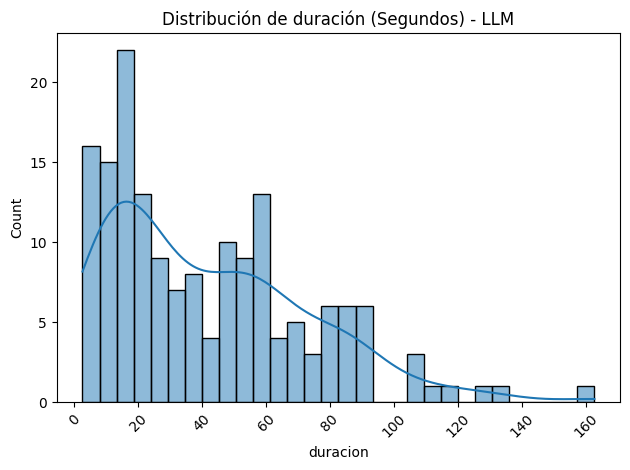

In [ ]:
sns.histplot(data=subset_debug_llm_df, x='duracion', bins=30, kde=True)
plt.title('Distribución de duración (Segundos) - LLM')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Boxplot - Duracion

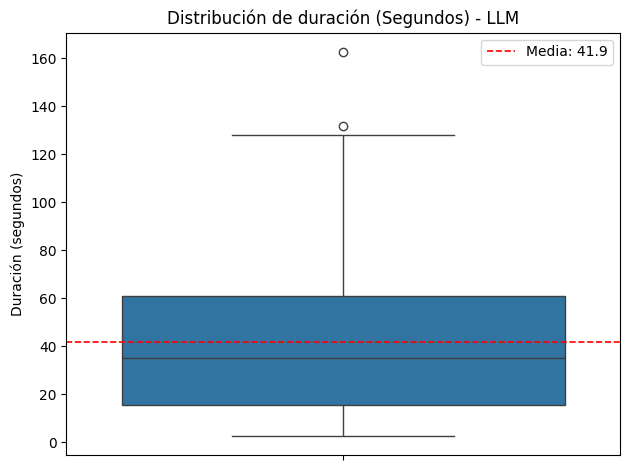

In [ ]:
media_d = subset_debug_llm_df['duracion'].mean()

sns.boxplot(data=subset_debug_llm_df, y='duracion')
plt.axhline(media_d, color='red', linestyle='--', linewidth=1.2, label=f'Media: {media_d:.1f}')
plt.legend()
plt.title('Distribución de duración (Segundos) - LLM')
plt.ylabel('Duración (segundos)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Boxplot - Tokens por segundo

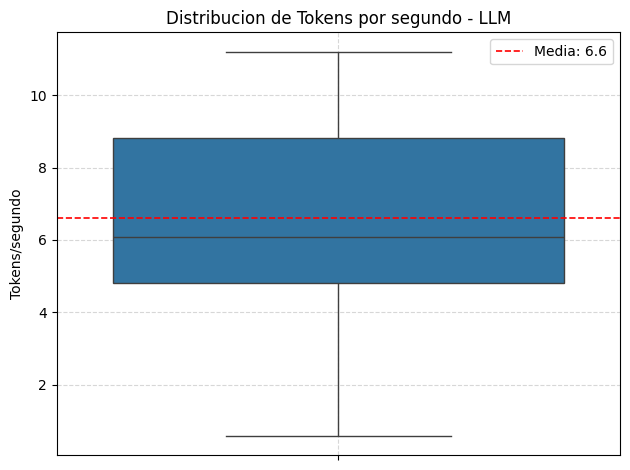

In [ ]:
media_ts = subset_debug_llm_df['token_segundo'].mean()

sns.boxplot(data=subset_debug_llm_df, y='token_segundo')
plt.axhline(media_ts, color='red', linestyle='--', linewidth=1.2, label=f'Media: {media_ts:.1f}')
plt.title('Distribucion de Tokens por segundo - LLM')
plt.ylabel('Tokens/segundo')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

#### Lineplot -  Tendencia consumo

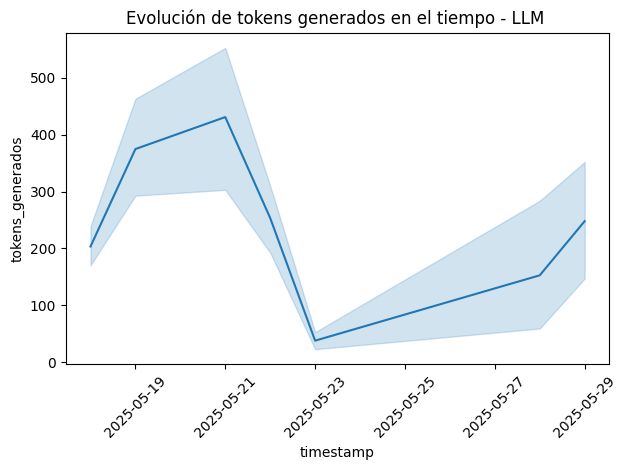

In [ ]:
sns.lineplot(data=subset_debug_llm_df, x='timestamp', y='tokens_generados')
plt.title('Evolución de tokens generados en el tiempo - LLM ')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Traductor - MarianMT

In [ ]:
traductor_df = pd.read_csv(TRADUCTOR_LOG_PATH, delimiter='|')

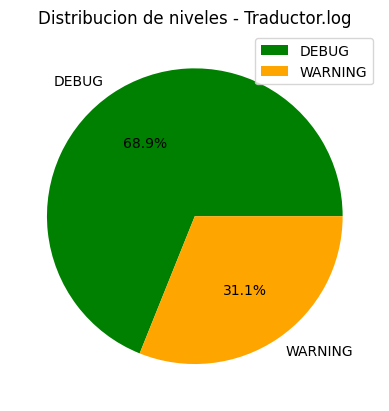

In [ ]:
traductor_df['level'].value_counts().plot(
    kind='pie',
    autopct='%1.1f%%',
    colors=['green', 'orange', 'red'],  
    ylabel=''  
)

plt.title('Distribucion de niveles - Traductor.log')
plt.legend()
plt.show()

#### Generacion del dataframe

In [ ]:
subset_debug_traductor = traductor_df[traductor_df['level'] == 'DEBUG']

In [ ]:
timestamp = []
duracion_segundos = []
Caracteres_input = []
Caracteres_output = []
Ratio = []
Categoria = []
for row in subset_debug_traductor.itertuples():
    timestamp.append(datetime.strptime(row.timestamp, "%Y-%m-%d %H:%M:%S,%f").date())
    split_message = row.message.split(',')
    duracion_segundos.append(float(split_message[0].split('-')[1].strip()))
    Caracteres_input.append(int(split_message[1].split('-')[1].strip()))
    Caracteres_output.append(int(split_message[2].split('-')[1].strip()))
    Ratio.append(float(split_message[3].split('-')[1].strip()))
    Categoria.append(split_message[4].split('-')[1].strip())

subset_debug_traductor_df = pd.DataFrame({
    'timestamp': timestamp,
    'duracion_segundos':duracion_segundos,
    'Caracteres_input': Caracteres_input,
    'Caracteres_output':Caracteres_output,
    'Ratio':Ratio,
    'Categoria':Categoria
})

In [ ]:
Caracteres_input_mean = subset_debug_traductor_df['Caracteres_input'].mean()
duracion_media = subset_debug_traductor_df['duracion_segundos'].mean()

#### Scatterplot - Duracion Vs Input

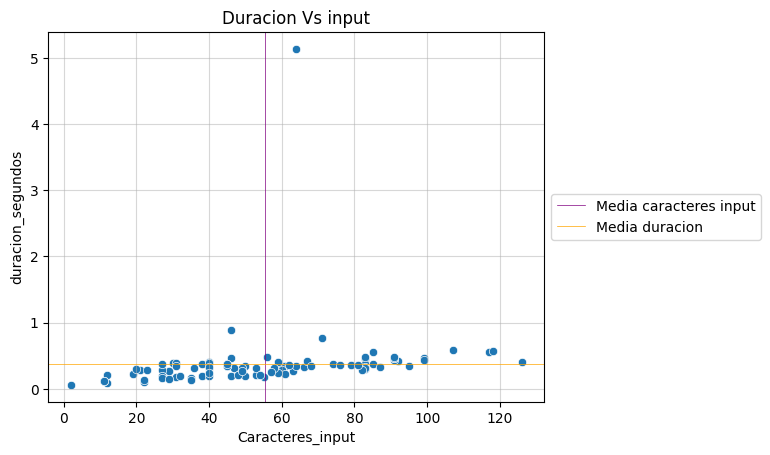

In [ ]:
sns.scatterplot(data=subset_debug_traductor_df, x='Caracteres_input', y='duracion_segundos')
plt.title('Duracion Vs input')
plt.axvline(Caracteres_input_mean, color='purple', linestyle='-', linewidth=0.5, label='Media caracteres input')
plt.axhline(duracion_media, color='orange', linestyle='-', linewidth=0.5, label='Media duracion')
plt.grid(True, linestyle='-', alpha=0.5)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

#### Scatterplot - Input Vs Output

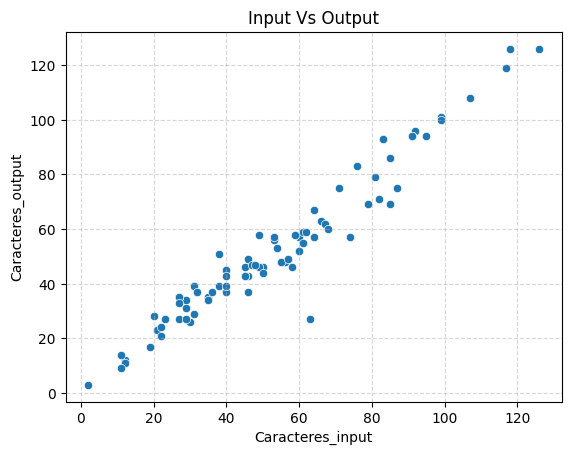

In [ ]:
sns.scatterplot(data=subset_debug_traductor_df, x='Caracteres_input', y='Caracteres_output')
plt.title('Input Vs Output')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

#### Boxplots por categoria - Distribucion del Ratio

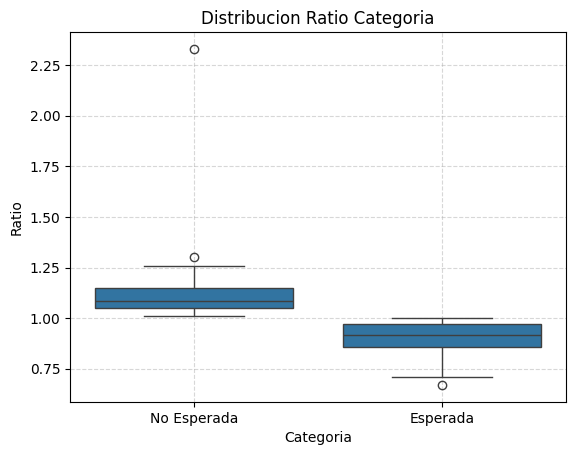

In [ ]:
sns.boxplot(data=subset_debug_traductor_df,x='Categoria', y='Ratio' )
plt.title('Distribucion Ratio Categoria')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

#### Boxplot - Duracion

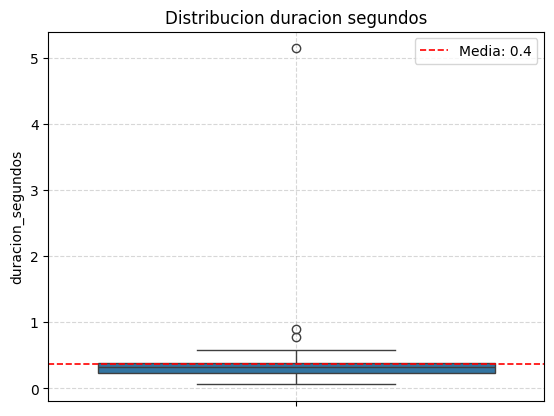

In [ ]:
media_d = subset_debug_traductor_df['duracion_segundos'].mean()

sns.boxplot(data=subset_debug_traductor_df, y='duracion_segundos' )
plt.axhline(media_d, color='red', linestyle='--', linewidth=1.2, label=f'Media: {media_d:.1f}')
plt.title('Distribucion duracion segundos')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [ ]:
subset_debug_traductor_df[subset_debug_traductor_df['duracion_segundos'] > 0.5]

,timestamp,duracion_segundos,Caracteres_input,Caracteres_output,Ratio,Categoria
31,2025-05-18,0.58,107,108,0.99,Esperada
33,2025-05-19,0.55,85,86,0.99,Esperada
34,2025-05-19,0.56,117,119,0.98,Esperada
57,2025-05-21,0.57,118,126,0.94,Esperada
61,2025-05-21,0.89,46,37,1.24,No Esperada
65,2025-05-22,5.14,64,57,1.12,No Esperada
69,2025-05-22,0.77,71,75,0.95,Esperada


In [ ]:
subset_debug_traductor_df['Categoria'].value_counts().reset_index()

,Categoria,count
0,Esperada,56
1,No Esperada,46


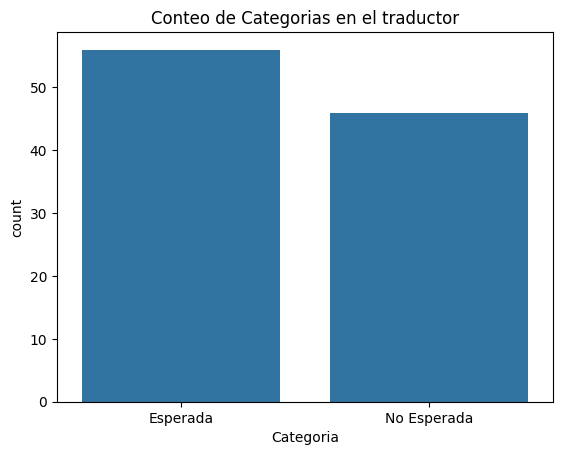

In [ ]:
sns.barplot(data=subset_debug_traductor_df['Categoria'].value_counts().reset_index(), x='Categoria', y='count')
plt.title("Conteo de Categorias en el traductor")
plt.show()